# Scene Model Training Notebook

This notebook provides an interactive environment for training Scene Models on the FindingEmo dataset.

## Features
- V-A regression with WMSE loss
- Emo8 classification with UCE loss
- Multiple backbone support (DINOv3, CLIP, ImageNet)
- Automatic learning rate detection
- Real-time training visualization
- Comprehensive evaluation and plotting

## Quick Start
1. Set your dataset path in the configuration section
2. Choose your model configuration
3. Run training cells sequentially
4. Analyze results in the evaluation section


## 1. Setup and Imports


In [1]:
import os
import sys
from pathlib import Path
import warnings
import traceback
from datetime import datetime

# Setup project paths (robust)
def _find_project_root(start: Path | None = None) -> Path:
    p = Path.cwd() if start is None else Path(start).resolve()
    for _ in range(6):
        if (p / ".git").exists() or (p / "data").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd()

PROJECT_ROOT = _find_project_root()
SRC_PATH = PROJECT_ROOT / "src"
DATA_ROOT = PROJECT_ROOT / "data"

# Add paths to sys.path
for path in [str(PROJECT_ROOT), str(SRC_PATH)]:
    if path not in sys.path:
        sys.path.insert(0, path)

print(f"📂 Project Root: {PROJECT_ROOT}")
print(f"📂 Source Path: {SRC_PATH}")
print(f"✅ Paths configured")

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")
warnings.filterwarnings("ignore", category=FutureWarning)


📂 Project Root: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO
📂 Source Path: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/src
✅ Paths configured


In [2]:
# Core imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import logging

# Project imports
from src.utils.config import create_arg_parser, load_config
from src.utils.device import DeviceManager
from src.utils.logging_utils import setup_logging
from src.utils.auto_lr import auto_detect_learning_rate
from src.data.datasets import create_dataset, create_dataloader
from src.data.transforms import create_transforms_from_config
from src.models.va_models import create_va_model
from src.training.losses import create_loss_function
from src.utils.metrics import evaluate_scene_model_predictions
from src.evaluation.evaluator import VAEvaluator

# Setup matplotlib for notebook
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports successful")


✅ All imports successful


## 2. Configuration

Choose your training configuration. You can either:
1. Use a predefined config file
2. Create a custom configuration inline


In [3]:
# === CONFIGURATION SECTION ===
# Modify these variables according to your setup

# Dataset path - resolved like CLIP notebook
FINDINGEMO_PATH = str(DATA_ROOT)  # Use repo data directory
MODEL_NAME = "scene_clip_vit_b32_frozen_notebook"

# Choose configuration approach
USE_CONFIG_FILE = False  # Set to False to use inline configuration

# Option 1: Use existing config file (used when USE_CONFIG_FILE = True)
CONFIG_FILE = PROJECT_ROOT / "configs/scene_models/scene_model_clip_vit_b32_frozen_auto_lr_config.yaml"

# Option 2: Inline configuration (used when USE_CONFIG_FILE = False)
# Replace the INLINE_CONFIG with this complete version:
INLINE_CONFIG = {
    "model": {
        "model_name": MODEL_NAME,
        "backbone_type": "clip",
        "clip_model_name": "ViT-B/32",
        "feature_dim": 512,
        "freeze_backbone": True,
        "head_config": {
            "hidden_dims": [256, 128],
            "dropout_rate": 0.3,
            "batch_norm": True,
            "activation": "relu"
        },
        # Output configuration
        "va_output_range": [-1, 1],                  # V-A range as per research
        "va_activation": "tanh",                     # Tanh for bounded output
        "emo8_classes": 8,                           # 8 Plutchik emotions
        "freeze_backbone": True,                     # Freeze CLIP parameters
        "unfreeze_epochs": None                     # Keep frozen throughout training
    },
    "training": {
        "learning_rate": "auto", # use auto to detect optimal LR using lr_finder
        "batch_size": 32,
        "num_epochs": 50,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "optimizer_config": {
            "weight_decay": 0.01,
            "betas": [0.9, 0.999]
        },
        "scheduler_config": {
            "step_size": 10,
            "gamma": 0.1,
            "min_lr": 1e-6
        },
        "loss": {
            "type": "combined",
            "va_loss_weight": 1.0,
            "emo8_loss_weight": 0.1,
            "use_focal_loss": False
        },
        "early_stopping": {
            "enabled": True,
            "patience": 5,
            "monitor_metric": "va_mae_avg",
            "mode": "min"
        }
    },
    "data": {
        "dataset_type": "findingemo",
        "findingemo_path": FINDINGEMO_PATH,
        # Optional quick-run controls (set one of these)
        "subset_fraction": None,            # e.g., 0.1 to use 10% of each split
        "max_samples_per_split": None,      # e.g., 500 to cap per split

        "train_split": 0.7,
        "val_split": 0.15,
        "test_split": 0.15,

        "stratify_on": ["emo8", "valence_bin", "arousal_bin"],
        "save_split_indices": True,
        "load_split_indices": True,

        # CLIP-specific preprocessing: CLIP ViT-B/32 expects 224x224 square images
        "image_size": 224,                  # CLIP ViT-B/32 input size
        "keep_aspect_ratio": False,         # CLIP expects square images
        "use_backbone_specific": True,      # Use CLIP normalization

        # Augmentation (conservative for CLIP)
        "augmentation": {
            "enabled": True,
            "horizontal_flip": 0.5,
            "rotation": 15,                 # Less rotation for CLIP
            "crop_scale": [0.85, 1.0],      # Less aggressive cropping
            "perspective_transform": 0.1,   # Minimal perspective for CLIP
            "color_jitter": {
                "brightness": 0.25,         # More conservative color jitter
                "contrast": 0.25,
                "saturation": 0.15,
                "hue": 0.05
            },
            "gaussian_blur": 0.05 # Minimal blur for CLIP
        }
    }
}

# Validate paths
if not Path(FINDINGEMO_PATH).exists():
    print(f"❌ Error: FindingEmo path does not exist: {FINDINGEMO_PATH}")
    print("Please update FINDINGEMO_PATH variable above")
else:
    print(f"✅ FindingEmo dataset found at: {FINDINGEMO_PATH}")

if USE_CONFIG_FILE and not CONFIG_FILE.exists():
    print(f"❌ Warning: Config file not found: {CONFIG_FILE}")
    print("Will use inline configuration instead")
    USE_CONFIG_FILE = False

print(f"📋 Configuration mode: {'File-based' if USE_CONFIG_FILE else 'Inline'}")


✅ FindingEmo dataset found at: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/data
📋 Configuration mode: Inline


## 3. Load Configuration and Setup


In [4]:
# Load configuration
if USE_CONFIG_FILE:
    # Create minimal args for config loading
    class Args:
        def __init__(self):
            self.config = str(CONFIG_FILE)
            # Override dataset path
            setattr(self, 'data.findingemo_path', FINDINGEMO_PATH)
    
    args = Args()
    config = load_config(CONFIG_FILE, args)
    # Force checkpoints under notebooks/checkpoints/<model>
    try:
        config.checkpointing.save_dir = str(PROJECT_ROOT / 'notebooks' / 'checkpoints' / MODEL_NAME)
    except Exception:
        pass
    print(f"✅ Loaded config from: {CONFIG_FILE}")
else:
    # Use inline configuration
    from src.utils.config import DictConfig
    
    # Add default values for missing sections
    # Stable run timestamp used across results + logs
    RUN_TS = datetime.now().strftime('%Y%m%d_%H%M%S')

    default_config = {
        "hardware": {
            "device": "auto",
            "mixed_precision": True,
            "num_workers": 4,
            "pin_memory": True
        },
        "reproducibility": {
            "seed": 42
        },
        "logging": {
            "log_every_n_steps": 50,
            "experiment_name": f"notebook_training_{RUN_TS}"
        },
        "checkpointing": {
            "save_dir": str(PROJECT_ROOT / "notebooks" / "checkpoints" / MODEL_NAME),
            "save_every_n_epochs": 5,
            "save_best_only": False,
            "monitor_metric": "va_mae_avg",
            "save_optimizer": True,
            "save_scheduler": True
        },
        "evaluation": {
            "metrics": ["mae", "mse", "rmse", "ccc", "pearson", "spearman"],
            "compute_per_quadrant": True,
            "save_predictions": True,
            "emo8_metrics": ["weighted_f1", "macro_f1", "accuracy"]
        }
    }
    
    # Merge configurations
    full_config = {**default_config, **INLINE_CONFIG}
    config = DictConfig(full_config)
    print("✅ Using inline configuration")

# Display key configuration
print("\n📋 Key Configuration:")
print(f"   Model: {config.model.model_name}")
print(f"   Backbone: {config.model.backbone_type}")
print(f"   Learning Rate: {config.training.learning_rate}")
print(f"   Batch Size: {config.training.batch_size}")
print(f"   Epochs: {config.training.num_epochs}")
print(f"   Dataset: {config.data.dataset_type}")


✅ Using inline configuration

📋 Key Configuration:
   Model: scene_clip_vit_b32_frozen_notebook
   Backbone: clip
   Learning Rate: auto
   Batch Size: 32
   Epochs: 50
   Dataset: findingemo


In [5]:
# Setup reproducibility
torch.manual_seed(config.reproducibility.seed)
torch.cuda.manual_seed_all(config.reproducibility.seed)
np.random.seed(config.reproducibility.seed)

# Setup device management
device_manager = DeviceManager(
    device=config.hardware.device,
    mixed_precision=config.hardware.mixed_precision,
    verbose=True
)

# Setup logging (simplified for notebook)
logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

print(f"✅ Setup complete - Using device: {device_manager.device}")



🔧 Device Manager Information
Selected Device: mps
Mixed Precision: False
Apple Silicon: MPS backend available
PyTorch Version: 2.8.0
✅ Setup complete - Using device: mps


## 4. Auto Learning Rate Detection (Optional)


In [6]:
from scripts.train_scene_model import SceneModelTrainer

# Auto-detect learning rate if needed
if (hasattr(config.training, 'learning_rate') and 
    (config.training.learning_rate == 'auto' or str(config.training.learning_rate).lower() == 'auto')):
    
    print("🤖 Auto-detecting optimal learning rate...")
    
    # Temporarily set a default learning rate for trainer creation
    original_lr = config.training.learning_rate
    config.training.learning_rate = 1e-4  # Default for auto detection

    # Create temporary trainer to get data loaders
    temp_trainer = SceneModelTrainer(config, device_manager, logger)

    # Run auto LR detection
    optimal_lr, lr_info = auto_detect_learning_rate(
        model=temp_trainer.model,
        backbone_type=getattr(config.model, 'backbone_type', 'clip'),
        freeze_backbone=getattr(config.model, 'freeze_backbone', True),
        batch_size=config.training.batch_size,
        device=device_manager.device,
        train_loader=temp_trainer.train_loader,
        use_lr_finder=False,
        num_epochs=getattr(config.training, 'num_epochs', 50)
    )
    
    # Update learning rate
    config.training.learning_rate = optimal_lr

    # Clean up temporary trainer
    del temp_trainer
    
    ## Recreate optimizer with new learning rate
    #for param_group in trainer.optimizer.param_groups:
    #    param_group['lr'] = optimal_lr
    
    print(f"✅ Auto-detected learning rate: {optimal_lr:.2e}")
    print(f"📊 Detection method: {lr_info['method']}")
    print(f"🎯 Backbone: {lr_info['backbone_type']} ({'frozen' if lr_info['frozen'] else 'unfrozen'})")
    print(f"📈 Empirical range: {lr_info['empirical_range'][0]:.2e} - {lr_info['empirical_range'][1]:.2e}")

    # Optionally update scheduler config
    if 'schedule_config' in lr_info and hasattr(config.training, 'scheduler'):
        schedule_config = lr_info['schedule_config']
        if hasattr(config.training, 'warmup_epochs'):
            config.training.warmup_epochs = schedule_config['warmup_epochs']
        if hasattr(config.training, 'min_lr'):
            config.training.min_lr = schedule_config['min_lr']
        
        print(f"📈 Updated scheduler config:")
        print(f"   Warmup epochs: {schedule_config['warmup_epochs']}")
        print(f"   Min LR: {schedule_config['min_lr']:.2e}")
else:
    print(f"📋 Using configured learning rate: {config.training.learning_rate}")


🤖 Auto-detecting optimal learning rate...


✅ Auto-detected learning rate: 1.00e-04
📊 Detection method: empirical
🎯 Backbone: clip (frozen)
📈 Empirical range: 5.00e-05 - 5.00e-04
📈 Updated scheduler config:
   Warmup epochs: 2
   Min LR: 1.00e-06


## 5. Notebook Scene Model Trainer

This is a notebook-adapted version of the SceneModelTrainer class with enhanced visualization and interactivity.


In [7]:
# Import the trainer class from the original script
# We'll adapt it for notebook use

# Create trainer instance
trainer = SceneModelTrainer(config, device_manager, logger)

print("🎉 Trainer initialized and ready for training!")
print(f"📊 Dataset sizes: Train={len(trainer.train_loader.dataset)}, Val={len(trainer.val_loader.dataset)}, Test={len(trainer.test_loader.dataset)}")
print(f"🧠 Model: {config.model.model_name}")
print(f"🎯 Monitor metric: {config.training.early_stopping.monitor_metric}")


🎉 Trainer initialized and ready for training!
📊 Dataset sizes: Train=13149, Val=1632, Test=1651
🧠 Model: scene_clip_vit_b32_frozen_notebook
🎯 Monitor metric: va_mae_avg


## 6. Training with Progress Visualization


In [8]:
# Enhanced training function with notebook-friendly progress bars
def train_epoch_notebook(trainer, epoch):
    """Train for one epoch with tqdm progress bar."""
    trainer.model.train()
    total_loss = 0.0
    
    # Use tqdm for progress visualization
    progress_bar = tqdm(trainer.train_loader, desc=f"Epoch {epoch:3d}", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        batch = {k: v.to(trainer.device_manager.device) if torch.is_tensor(v) else v 
                for k, v in batch.items()}
        
        # Forward pass (same as original)
        if trainer.scaler and trainer.device_manager.device.type == "cuda":
            with torch.cuda.amp.autocast():
                predictions = trainer.model(batch['image'])
                targets = {
                    'valence': batch['valence'],
                    'arousal': batch['arousal']
                }
                if 'emo8_label' in batch:
                    targets['emo8_label'] = batch['emo8_label']
                
                loss_dict = trainer.criterion(predictions, targets, batch)
                loss = loss_dict['total_loss']
            
            trainer.optimizer.zero_grad()
            trainer.scaler.scale(loss).backward()
            trainer.scaler.step(trainer.optimizer)
            trainer.scaler.update()
        else:
            predictions = trainer.model(batch['image'])
            targets = {
                'valence': batch['valence'],
                'arousal': batch['arousal']
            }
            if 'emo8_label' in batch:
                targets['emo8_label'] = batch['emo8_label']
            
            loss_dict = trainer.criterion(predictions, targets, batch)
            loss = loss_dict['total_loss']
            
            trainer.optimizer.zero_grad()
            loss.backward()
            trainer.optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'LR': f'{trainer.optimizer.param_groups[0]["lr"]:.2e}'
        })
    
    return total_loss / len(trainer.train_loader)


def plot_training_progress(history):
    """Plot training progress in real-time."""
    if not history.get('train_loss'):
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Training loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', linewidth=2)
    axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Validation MAE
    if history.get('val_mae'):
        axes[0, 1].plot(epochs, history['val_mae'], 'r-', linewidth=2)
        axes[0, 1].set_title('Validation V-A MAE', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('MAE')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate
    if history.get('learning_rates'):
        axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
        axes[1, 0].set_title('Learning Rate', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Additional metrics
    if history.get('val_f1'):
        axes[1, 1].plot(epochs, history['val_f1'], 'm-', linewidth=2)
        axes[1, 1].set_title('Validation Emo8 F1', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("✅ Notebook training functions defined")


✅ Notebook training functions defined


## 7. Checkpoint Management Functions

Following the original script's checkpoint functionality.


In [9]:
# Add checkpoint saving functionality to the trainer class
def add_checkpoint_methods_to_trainer(trainer):
    """Add checkpoint saving methods to the trainer instance."""
    
    def _save_checkpoint(self, epoch, is_best=False):
        """Save model checkpoint (.pth full + .pkl weights-only) using shared utility."""
        from src.utils.checkpoints import save_checkpoint_bundle
        checkpoint_dir = Path(self.config.checkpointing.save_dir if hasattr(self.config, 'checkpointing') 
                             else "./checkpoints/notebook_training")
        paths = save_checkpoint_bundle(
            checkpoint_dir=checkpoint_dir,
            epoch=epoch,
            model=self.model,
            optimizer=self.optimizer,
            best_metric=self.best_metric,
            config=self.config,
            scheduler=self.scheduler,
            is_best=is_best,
        )
        if is_best:
            print(f"💾 Saved best model: {paths['pth']} and {paths['pkl']}")
        return paths['pth']
    
    def _evaluate_test_set(self):
        """Evaluate on test set - matches original script implementation."""
        print("🧪 Evaluating on test set...")
        
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch in self.test_loader:
                batch = {k: v.to(self.device_manager.device) if torch.is_tensor(v) else v 
                        for k, v in batch.items()}
                
                predictions = self.model(batch['image'])
                
                all_predictions.append({
                    k: v.cpu() for k, v in predictions.items() if torch.is_tensor(v)
                })
                
                targets = {
                    'valence': batch['valence'].cpu(),
                    'arousal': batch['arousal'].cpu()
                }
                if 'emo8_label' in batch:
                    targets['emo8_label'] = batch['emo8_label'].cpu()
                
                all_targets.append(targets)
        
        # Concatenate results
        final_predictions = {}
        final_targets = {}
        
        for key in all_predictions[0].keys():
            final_predictions[key] = torch.cat([p[key] for p in all_predictions], dim=0)
        
        for key in all_targets[0].keys():
            final_targets[key] = torch.cat([t[key] for t in all_targets], dim=0)
        
        # Evaluate with detailed output
        test_metrics = evaluate_scene_model_predictions(
            predictions=final_predictions,
            targets=final_targets,
            verbose=True
        )
        
        return test_metrics
    
    # Bind methods to trainer instance
    import types
    trainer._save_checkpoint = types.MethodType(_save_checkpoint, trainer)
    trainer._evaluate_test_set = types.MethodType(_evaluate_test_set, trainer)
    
    print("✅ Checkpoint and evaluation methods added to trainer")

# Apply the methods to our trainer
add_checkpoint_methods_to_trainer(trainer)


✅ Checkpoint and evaluation methods added to trainer


## 8. Enhanced Training Loop

Updated training loop to match the original script's implementation with mixed precision, proper early stopping, and checkpoint saving.


In [10]:
# Enhanced training function with mixed precision support - matches original script
def train_epoch_enhanced(trainer, epoch):
    """Train for one epoch with mixed precision support - matches original script implementation."""
    trainer.model.train()
    
    total_loss = 0.0
    num_batches = len(trainer.train_loader)
    
    # Use tqdm for progress visualization
    progress_bar = tqdm(trainer.train_loader, desc=f"Epoch {epoch:3d}", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        batch = {k: v.to(trainer.device_manager.device) if torch.is_tensor(v) else v 
                for k, v in batch.items()}
        
        # Forward pass with mixed precision support (matches original script)
        if trainer.scaler and trainer.device_manager.device.type == "cuda":
            with torch.cuda.amp.autocast():
                predictions = trainer.model(batch['image'])
                
                # Prepare targets
                targets = {
                    'valence': batch['valence'],
                    'arousal': batch['arousal']
                }
                if 'emo8_label' in batch:
                    targets['emo8_label'] = batch['emo8_label']
                
                # Compute loss
                loss_dict = trainer.criterion(predictions, targets, batch)
                loss = loss_dict['total_loss']
            
            # Backward pass
            trainer.optimizer.zero_grad()
            trainer.scaler.scale(loss).backward()
            
            # Gradient clipping (from original script)
            if hasattr(trainer.config.training, 'grad_clip_norm'):
                trainer.scaler.unscale_(trainer.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    trainer.model.parameters(), 
                    trainer.config.training.grad_clip_norm
                )
            
            trainer.scaler.step(trainer.optimizer)
            trainer.scaler.update()
        else:
            # Standard training without mixed precision (from original script)
            predictions = trainer.model(batch['image'])
            
            targets = {
                'valence': batch['valence'],
                'arousal': batch['arousal']
            }
            if 'emo8_label' in batch:
                targets['emo8_label'] = batch['emo8_label']
            
            loss_dict = trainer.criterion(predictions, targets, batch)
            loss = loss_dict['total_loss']
            
            # Backward pass
            trainer.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping (from original script)
            if hasattr(trainer.config.training, 'grad_clip_norm'):
                torch.nn.utils.clip_grad_norm_(
                    trainer.model.parameters(),
                    trainer.config.training.grad_clip_norm
                )
            
            trainer.optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar with current metrics
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'LR': f'{trainer.optimizer.param_groups[0]["lr"]:.2e}'
        })
        
        # Log progress (matches original script frequency)
        if batch_idx % getattr(trainer.config.logging, 'log_every_n_steps', 50) == 0:
            print(f"\\nEpoch {epoch:3d} [{batch_idx:4d}/{num_batches:4d}] "
                  f"Loss: {loss.item():.4f} LR: {trainer.optimizer.param_groups[0]['lr']:.2e}")
    
    avg_loss = total_loss / num_batches
    return avg_loss

print("✅ Enhanced training function defined")


✅ Enhanced training function defined


🚀 Starting Scene Model training...
\n📊 Epoch 1/50


Epoch   0:   0%|          | 0/411 [00:00<?, ?it/s]

/opt/anaconda3/envs/P-SEM2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


\nEpoch   0 [   0/ 411] Loss: -0.1604 LR: 1.00e-04
\nEpoch   0 [  50/ 411] Loss: 0.3786 LR: 1.00e-04
\nEpoch   0 [ 100/ 411] Loss: 0.0437 LR: 1.00e-04
\nEpoch   0 [ 150/ 411] Loss: -0.3715 LR: 1.00e-04
\nEpoch   0 [ 200/ 411] Loss: 0.4529 LR: 1.00e-04
\nEpoch   0 [ 250/ 411] Loss: 0.0580 LR: 1.00e-04
\nEpoch   0 [ 300/ 411] Loss: 0.1609 LR: 1.00e-04
\nEpoch   0 [ 350/ 411] Loss: 0.2037 LR: 1.00e-04
\nEpoch   0 [ 400/ 411] Loss: 0.3442 LR: 1.00e-04
📊 Epoch   0 Results:
   Train Loss: 0.0539
   Val va_mae_avg: 0.7361
   Val MAE: 0.7361
🎯 New best va_mae_avg: 0.7361
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


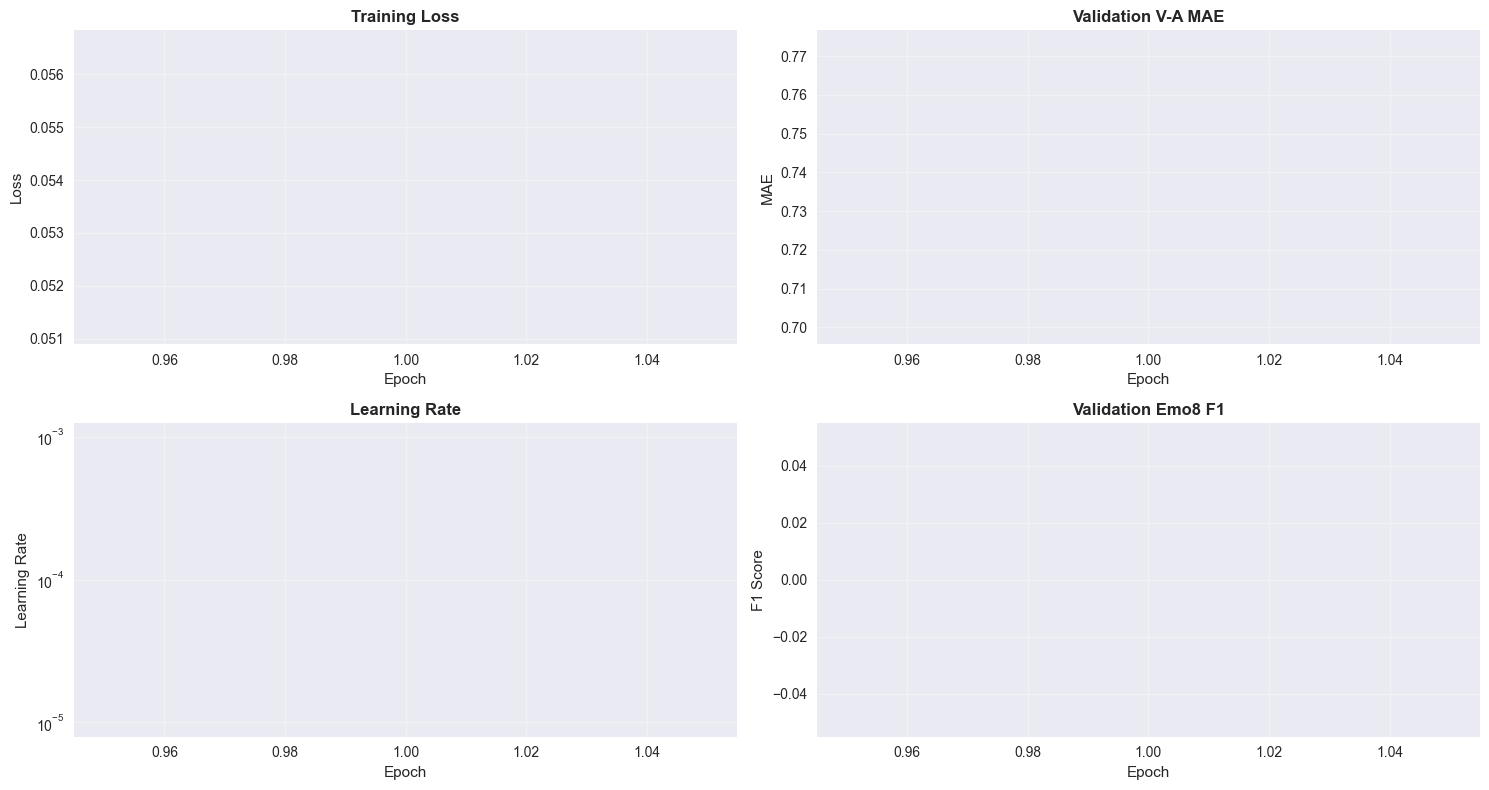

\n📊 Epoch 2/50


Epoch   1:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   1 [   0/ 411] Loss: -0.2490 LR: 9.99e-05
\nEpoch   1 [  50/ 411] Loss: 0.2271 LR: 9.99e-05
\nEpoch   1 [ 100/ 411] Loss: 0.1951 LR: 9.99e-05
\nEpoch   1 [ 150/ 411] Loss: 0.0510 LR: 9.99e-05
\nEpoch   1 [ 200/ 411] Loss: 0.4036 LR: 9.99e-05
\nEpoch   1 [ 250/ 411] Loss: -0.2405 LR: 9.99e-05
\nEpoch   1 [ 300/ 411] Loss: 0.1059 LR: 9.99e-05
\nEpoch   1 [ 350/ 411] Loss: 0.1353 LR: 9.99e-05
\nEpoch   1 [ 400/ 411] Loss: -0.2338 LR: 9.99e-05
📊 Epoch   1 Results:
   Train Loss: -0.0177
   Val va_mae_avg: 0.7121
   Val MAE: 0.7121
🎯 New best va_mae_avg: 0.7121
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


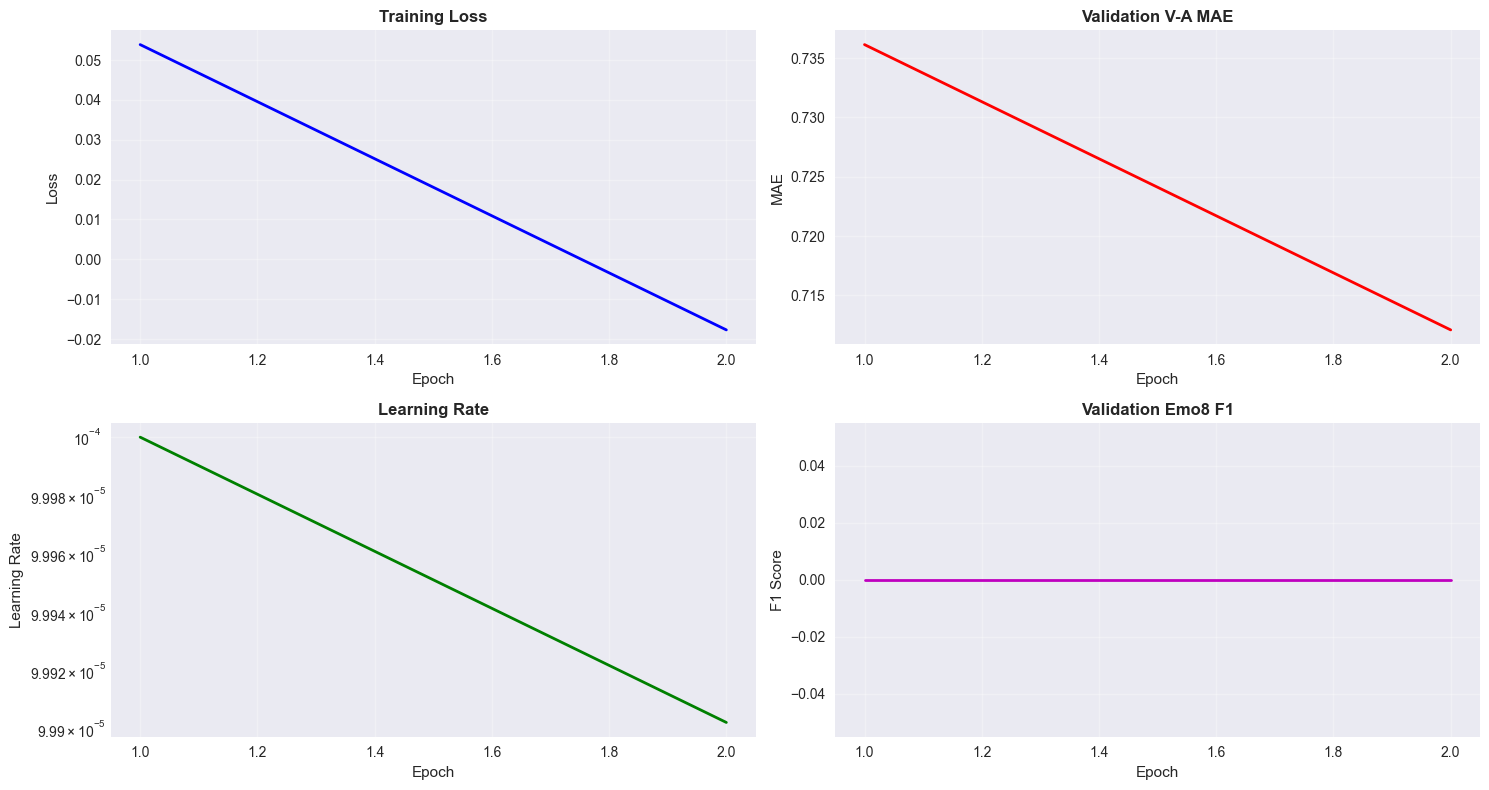

\n📊 Epoch 3/50


Epoch   2:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   2 [   0/ 411] Loss: -0.4564 LR: 9.96e-05
\nEpoch   2 [  50/ 411] Loss: 0.2815 LR: 9.96e-05
\nEpoch   2 [ 100/ 411] Loss: 0.3606 LR: 9.96e-05
\nEpoch   2 [ 150/ 411] Loss: 0.0174 LR: 9.96e-05
\nEpoch   2 [ 200/ 411] Loss: -0.3867 LR: 9.96e-05
\nEpoch   2 [ 250/ 411] Loss: 0.0454 LR: 9.96e-05
\nEpoch   2 [ 300/ 411] Loss: 0.4288 LR: 9.96e-05
\nEpoch   2 [ 350/ 411] Loss: -0.1736 LR: 9.96e-05
\nEpoch   2 [ 400/ 411] Loss: -0.0500 LR: 9.96e-05
📊 Epoch   2 Results:
   Train Loss: -0.0433
   Val va_mae_avg: 0.7296
   Val MAE: 0.7296
\n📊 Epoch 4/50


Epoch   3:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   3 [   0/ 411] Loss: -1.1136 LR: 9.91e-05
\nEpoch   3 [  50/ 411] Loss: -0.0553 LR: 9.91e-05
\nEpoch   3 [ 100/ 411] Loss: -0.4853 LR: 9.91e-05
\nEpoch   3 [ 150/ 411] Loss: 0.2835 LR: 9.91e-05
\nEpoch   3 [ 200/ 411] Loss: 0.0095 LR: 9.91e-05
\nEpoch   3 [ 250/ 411] Loss: 0.1921 LR: 9.91e-05
\nEpoch   3 [ 300/ 411] Loss: -0.5184 LR: 9.91e-05
\nEpoch   3 [ 350/ 411] Loss: 0.3582 LR: 9.91e-05
\nEpoch   3 [ 400/ 411] Loss: -0.1754 LR: 9.91e-05
📊 Epoch   3 Results:
   Train Loss: -0.0688
   Val va_mae_avg: 0.7085
   Val MAE: 0.7085
🎯 New best va_mae_avg: 0.7085
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


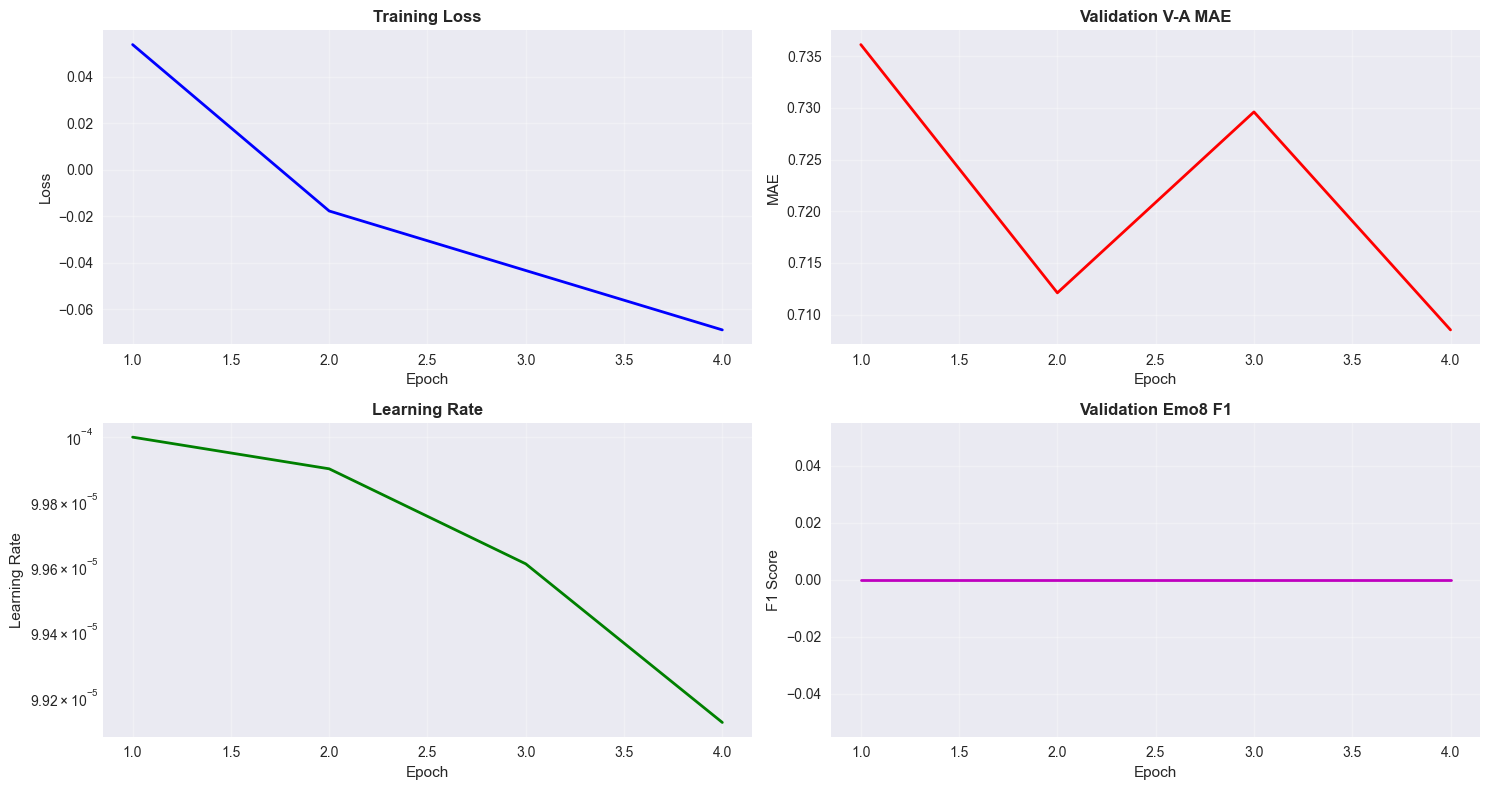

\n📊 Epoch 5/50


Epoch   4:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   4 [   0/ 411] Loss: -0.6083 LR: 9.84e-05
\nEpoch   4 [  50/ 411] Loss: 0.2422 LR: 9.84e-05
\nEpoch   4 [ 100/ 411] Loss: -0.0305 LR: 9.84e-05
\nEpoch   4 [ 150/ 411] Loss: -0.0129 LR: 9.84e-05
\nEpoch   4 [ 200/ 411] Loss: 0.2867 LR: 9.84e-05
\nEpoch   4 [ 250/ 411] Loss: -0.7099 LR: 9.84e-05
\nEpoch   4 [ 300/ 411] Loss: 0.0248 LR: 9.84e-05
\nEpoch   4 [ 350/ 411] Loss: -0.5843 LR: 9.84e-05
\nEpoch   4 [ 400/ 411] Loss: -0.0743 LR: 9.84e-05
📊 Epoch   4 Results:
   Train Loss: -0.0794
   Val va_mae_avg: 0.7122
   Val MAE: 0.7122


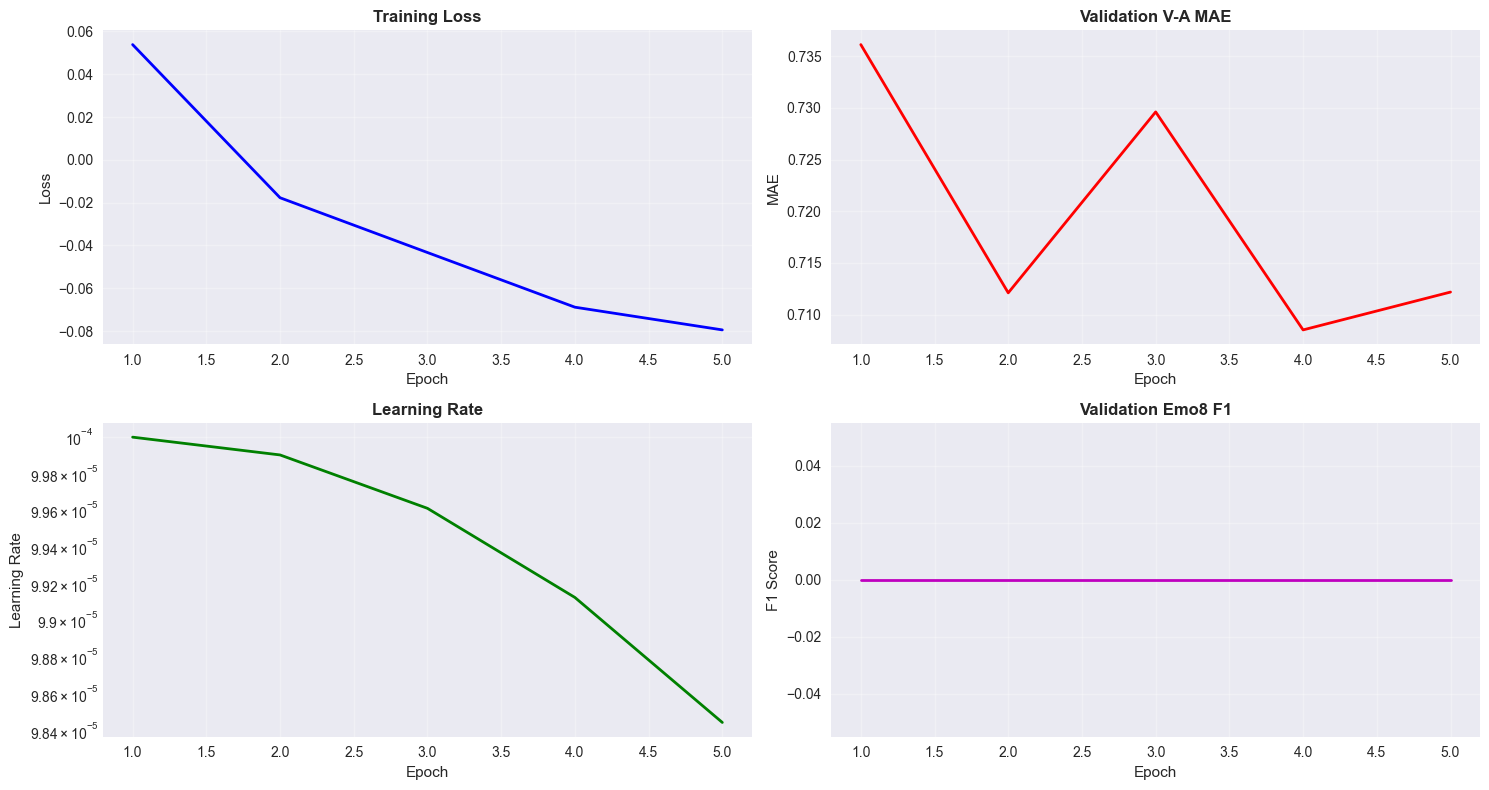

\n📊 Epoch 6/50


Epoch   5:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   5 [   0/ 411] Loss: 0.2370 LR: 9.76e-05
\nEpoch   5 [  50/ 411] Loss: 0.2119 LR: 9.76e-05
\nEpoch   5 [ 100/ 411] Loss: -0.1662 LR: 9.76e-05
\nEpoch   5 [ 150/ 411] Loss: -0.3147 LR: 9.76e-05
\nEpoch   5 [ 200/ 411] Loss: 0.1273 LR: 9.76e-05
\nEpoch   5 [ 250/ 411] Loss: 0.1674 LR: 9.76e-05
\nEpoch   5 [ 300/ 411] Loss: -0.0804 LR: 9.76e-05
\nEpoch   5 [ 350/ 411] Loss: 0.2303 LR: 9.76e-05
\nEpoch   5 [ 400/ 411] Loss: 0.1791 LR: 9.76e-05
📊 Epoch   5 Results:
   Train Loss: -0.0861
   Val va_mae_avg: 0.7005
   Val MAE: 0.7005
🎯 New best va_mae_avg: 0.7005
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


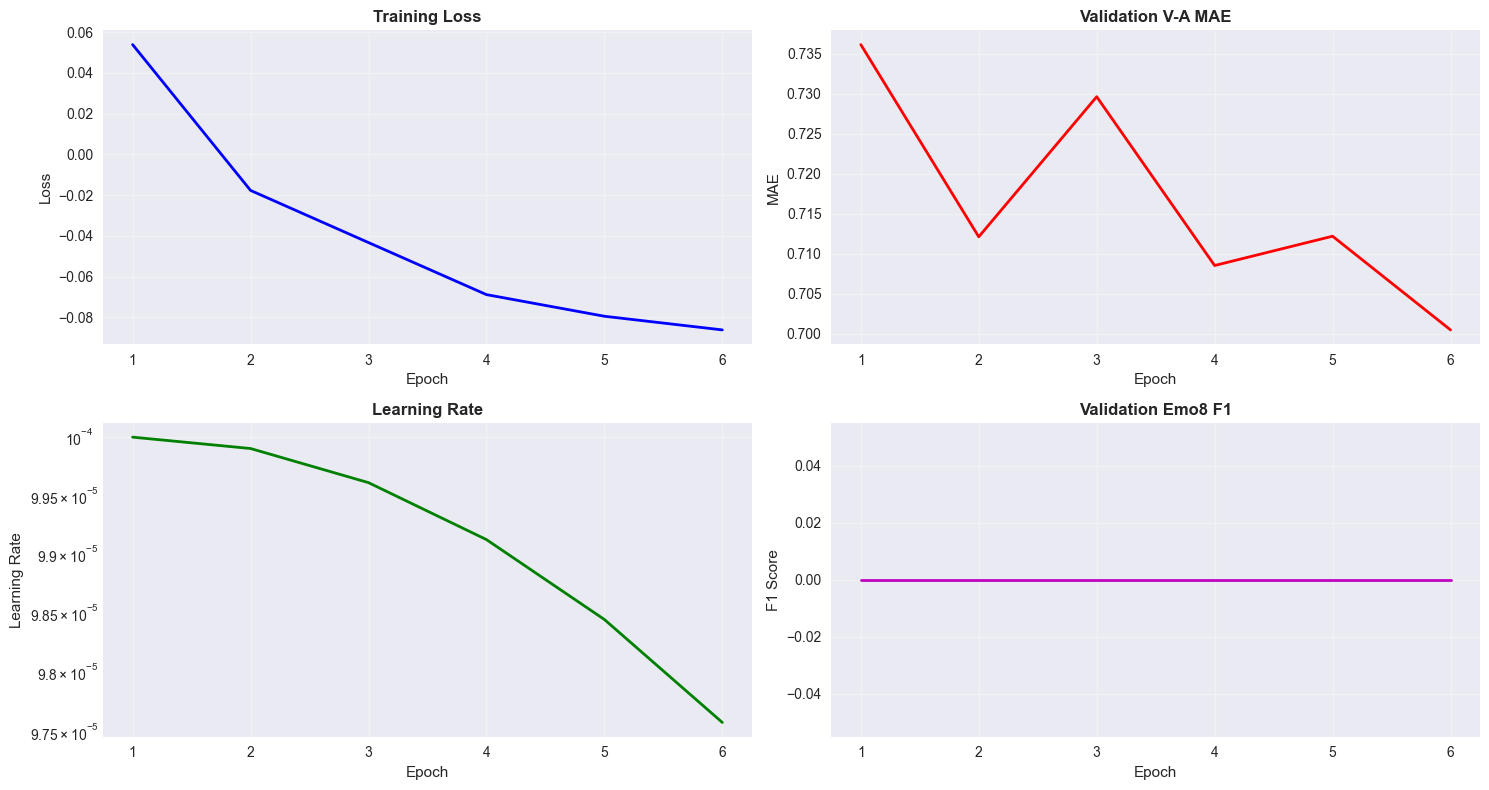

\n📊 Epoch 7/50


Epoch   6:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   6 [   0/ 411] Loss: -0.5779 LR: 9.65e-05
\nEpoch   6 [  50/ 411] Loss: -0.3699 LR: 9.65e-05
\nEpoch   6 [ 100/ 411] Loss: -0.8879 LR: 9.65e-05
\nEpoch   6 [ 150/ 411] Loss: -0.1758 LR: 9.65e-05
\nEpoch   6 [ 200/ 411] Loss: -0.2106 LR: 9.65e-05
\nEpoch   6 [ 250/ 411] Loss: -0.2438 LR: 9.65e-05
\nEpoch   6 [ 300/ 411] Loss: -0.4717 LR: 9.65e-05
\nEpoch   6 [ 350/ 411] Loss: -0.2522 LR: 9.65e-05
\nEpoch   6 [ 400/ 411] Loss: 0.3524 LR: 9.65e-05
📊 Epoch   6 Results:
   Train Loss: -0.1091
   Val va_mae_avg: 0.6996
   Val MAE: 0.6996
🎯 New best va_mae_avg: 0.6996
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


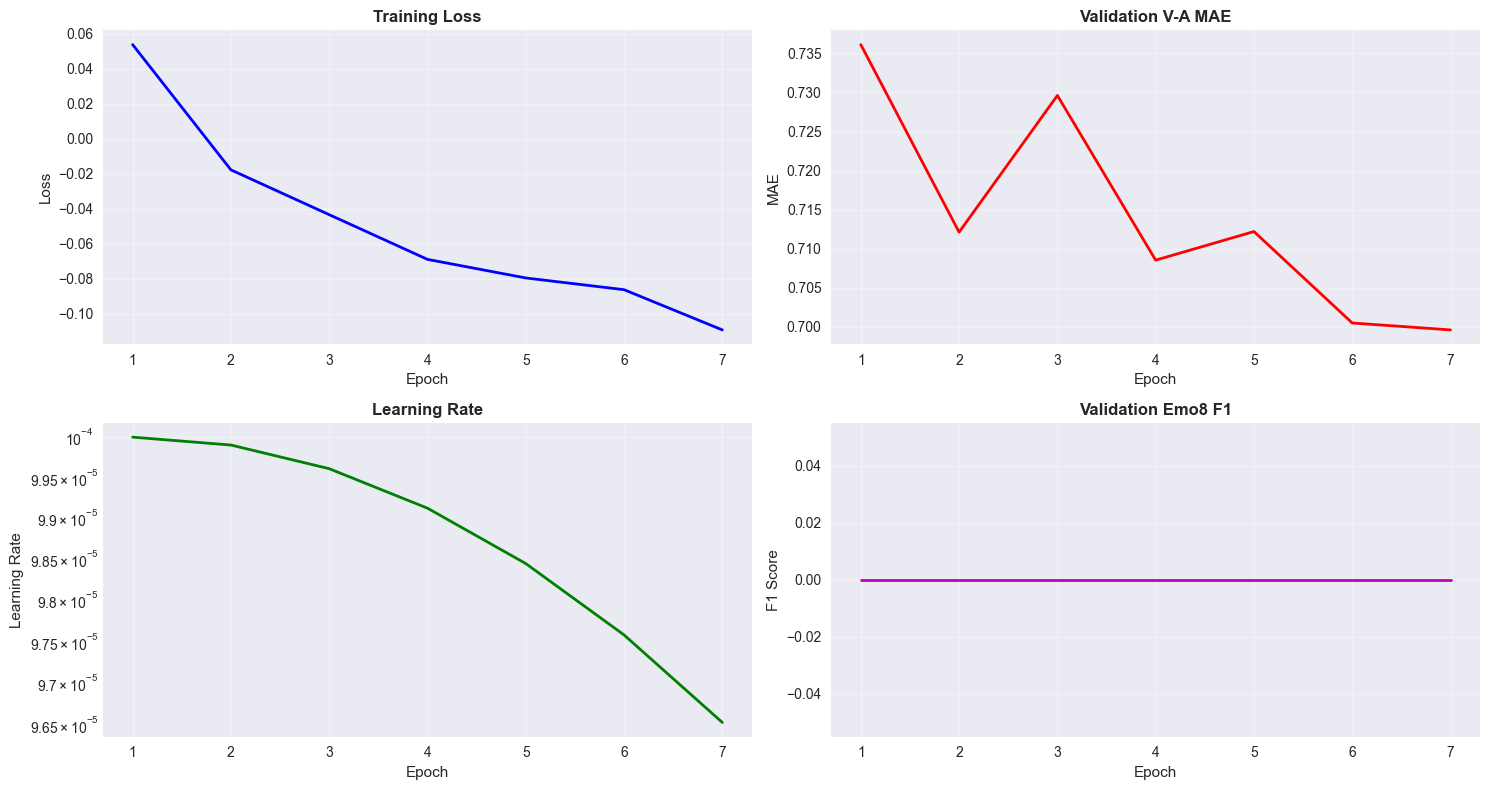

\n📊 Epoch 8/50


Epoch   7:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   7 [   0/ 411] Loss: -0.1120 LR: 9.53e-05
\nEpoch   7 [  50/ 411] Loss: -0.0961 LR: 9.53e-05
\nEpoch   7 [ 100/ 411] Loss: 0.1146 LR: 9.53e-05
\nEpoch   7 [ 150/ 411] Loss: -0.3787 LR: 9.53e-05
\nEpoch   7 [ 200/ 411] Loss: -0.0163 LR: 9.53e-05
\nEpoch   7 [ 250/ 411] Loss: -0.2031 LR: 9.53e-05
\nEpoch   7 [ 300/ 411] Loss: -0.0807 LR: 9.53e-05
\nEpoch   7 [ 350/ 411] Loss: 0.1401 LR: 9.53e-05
\nEpoch   7 [ 400/ 411] Loss: -0.1530 LR: 9.53e-05
📊 Epoch   7 Results:
   Train Loss: -0.1283
   Val va_mae_avg: 0.7023
   Val MAE: 0.7023
\n📊 Epoch 9/50


Epoch   8:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   8 [   0/ 411] Loss: 0.0268 LR: 9.39e-05
\nEpoch   8 [  50/ 411] Loss: 0.0467 LR: 9.39e-05
\nEpoch   8 [ 100/ 411] Loss: -0.2621 LR: 9.39e-05
\nEpoch   8 [ 150/ 411] Loss: 0.7090 LR: 9.39e-05
\nEpoch   8 [ 200/ 411] Loss: 0.1616 LR: 9.39e-05
\nEpoch   8 [ 250/ 411] Loss: -1.1650 LR: 9.39e-05
\nEpoch   8 [ 300/ 411] Loss: -0.5013 LR: 9.39e-05
\nEpoch   8 [ 350/ 411] Loss: -0.2670 LR: 9.39e-05
\nEpoch   8 [ 400/ 411] Loss: 0.0959 LR: 9.39e-05
📊 Epoch   8 Results:
   Train Loss: -0.1359
   Val va_mae_avg: 0.7056
   Val MAE: 0.7056
\n📊 Epoch 10/50


Epoch   9:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   9 [   0/ 411] Loss: -0.0987 LR: 9.23e-05
\nEpoch   9 [  50/ 411] Loss: -0.3044 LR: 9.23e-05
\nEpoch   9 [ 100/ 411] Loss: -0.5714 LR: 9.23e-05
\nEpoch   9 [ 150/ 411] Loss: -0.0152 LR: 9.23e-05
\nEpoch   9 [ 200/ 411] Loss: -0.2643 LR: 9.23e-05
\nEpoch   9 [ 250/ 411] Loss: -0.2783 LR: 9.23e-05
\nEpoch   9 [ 300/ 411] Loss: -0.7402 LR: 9.23e-05
\nEpoch   9 [ 350/ 411] Loss: 0.0120 LR: 9.23e-05
\nEpoch   9 [ 400/ 411] Loss: -1.3811 LR: 9.23e-05
📊 Epoch   9 Results:
   Train Loss: -0.1324
   Val va_mae_avg: 0.7032
   Val MAE: 0.7032


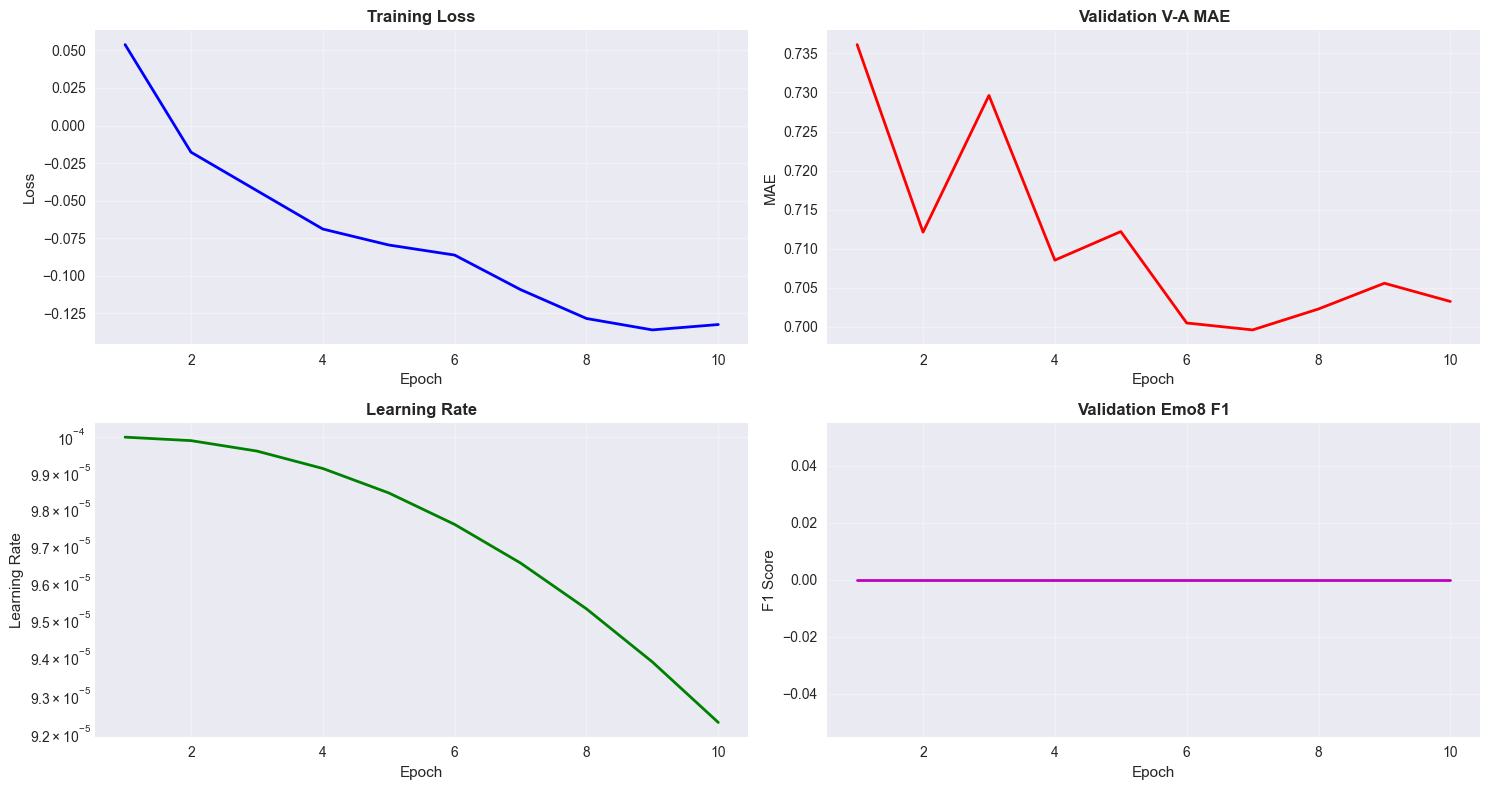

\n📊 Epoch 11/50


Epoch  10:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  10 [   0/ 411] Loss: 0.6310 LR: 9.05e-05
\nEpoch  10 [  50/ 411] Loss: 0.1385 LR: 9.05e-05
\nEpoch  10 [ 100/ 411] Loss: -0.2684 LR: 9.05e-05
\nEpoch  10 [ 150/ 411] Loss: -0.4965 LR: 9.05e-05
\nEpoch  10 [ 200/ 411] Loss: -0.1365 LR: 9.05e-05
\nEpoch  10 [ 250/ 411] Loss: -0.0345 LR: 9.05e-05
\nEpoch  10 [ 300/ 411] Loss: 0.0557 LR: 9.05e-05
\nEpoch  10 [ 350/ 411] Loss: 0.2253 LR: 9.05e-05
\nEpoch  10 [ 400/ 411] Loss: -0.3600 LR: 9.05e-05
📊 Epoch  10 Results:
   Train Loss: -0.1547
   Val va_mae_avg: 0.6962
   Val MAE: 0.6962
🎯 New best va_mae_avg: 0.6962
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


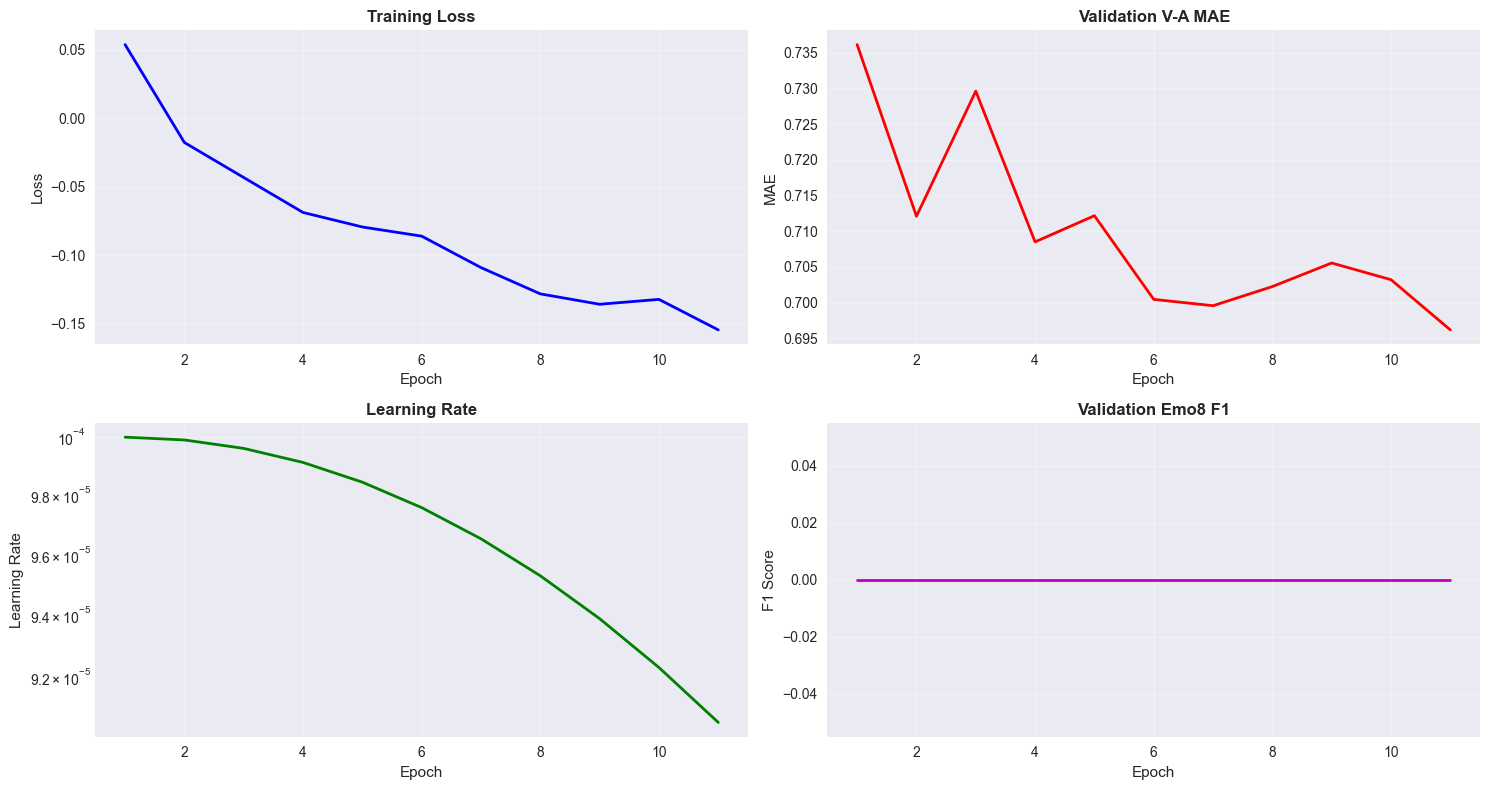

\n📊 Epoch 12/50


Epoch  11:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  11 [   0/ 411] Loss: -0.1027 LR: 8.86e-05
\nEpoch  11 [  50/ 411] Loss: -0.2291 LR: 8.86e-05
\nEpoch  11 [ 100/ 411] Loss: -0.9868 LR: 8.86e-05
\nEpoch  11 [ 150/ 411] Loss: -0.9091 LR: 8.86e-05
\nEpoch  11 [ 200/ 411] Loss: -0.2325 LR: 8.86e-05
\nEpoch  11 [ 250/ 411] Loss: -0.1383 LR: 8.86e-05
\nEpoch  11 [ 300/ 411] Loss: 0.1365 LR: 8.86e-05
\nEpoch  11 [ 350/ 411] Loss: 0.0846 LR: 8.86e-05
\nEpoch  11 [ 400/ 411] Loss: -0.3322 LR: 8.86e-05
📊 Epoch  11 Results:
   Train Loss: -0.1571
   Val va_mae_avg: 0.6934
   Val MAE: 0.6934
🎯 New best va_mae_avg: 0.6934
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


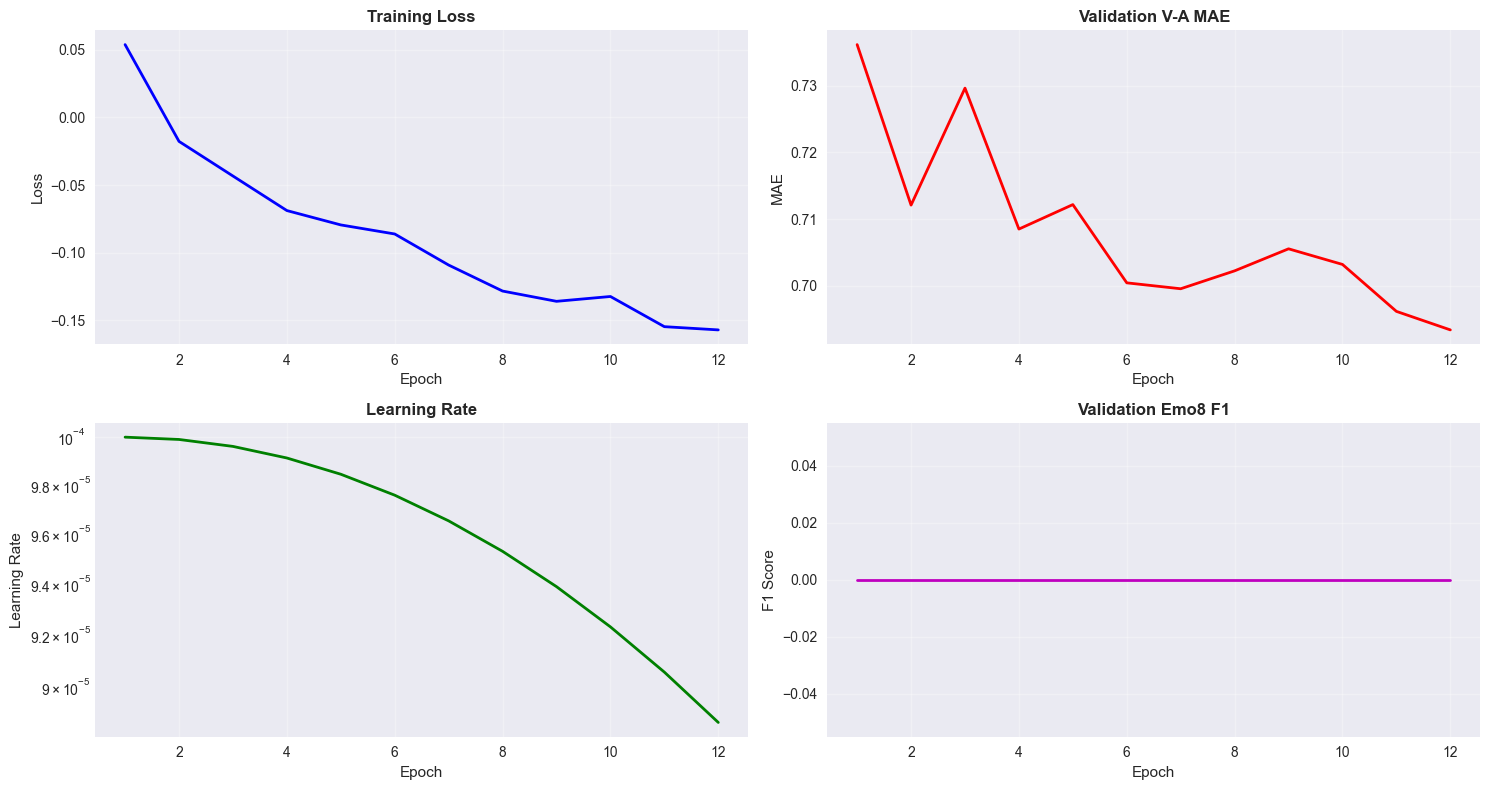

\n📊 Epoch 13/50


Epoch  12:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  12 [   0/ 411] Loss: -0.4596 LR: 8.66e-05
\nEpoch  12 [  50/ 411] Loss: -0.1340 LR: 8.66e-05
\nEpoch  12 [ 100/ 411] Loss: -0.1654 LR: 8.66e-05
\nEpoch  12 [ 150/ 411] Loss: 0.0159 LR: 8.66e-05
\nEpoch  12 [ 200/ 411] Loss: -1.2117 LR: 8.66e-05
\nEpoch  12 [ 250/ 411] Loss: -0.4290 LR: 8.66e-05
\nEpoch  12 [ 300/ 411] Loss: -0.1334 LR: 8.66e-05
\nEpoch  12 [ 350/ 411] Loss: -0.4736 LR: 8.66e-05
\nEpoch  12 [ 400/ 411] Loss: -0.1426 LR: 8.66e-05
📊 Epoch  12 Results:
   Train Loss: -0.1878
   Val va_mae_avg: 0.6902
   Val MAE: 0.6902
🎯 New best va_mae_avg: 0.6902
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


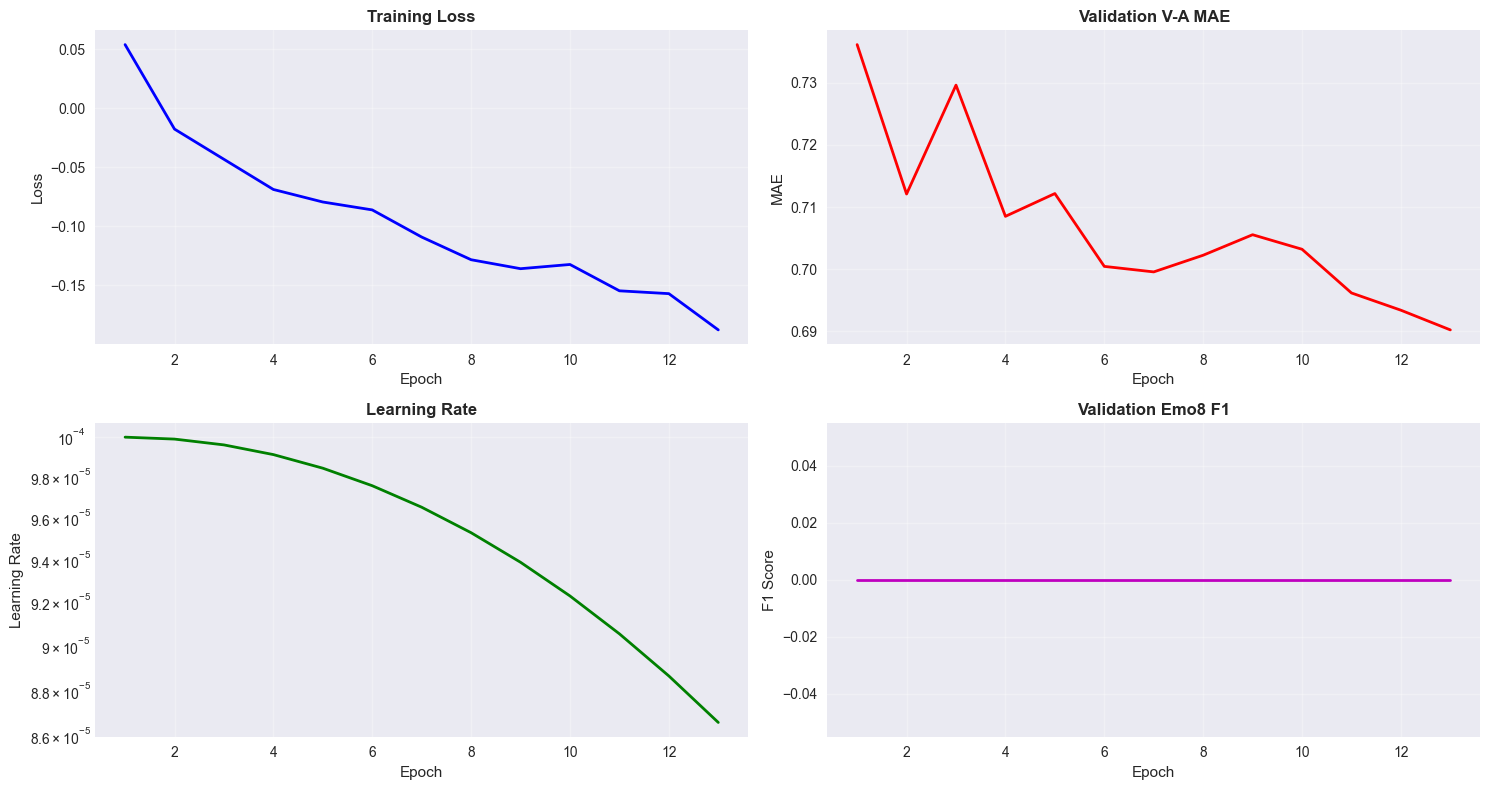

\n📊 Epoch 14/50


Epoch  13:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  13 [   0/ 411] Loss: -0.1872 LR: 8.44e-05
\nEpoch  13 [  50/ 411] Loss: -0.3462 LR: 8.44e-05
\nEpoch  13 [ 100/ 411] Loss: 0.0570 LR: 8.44e-05
\nEpoch  13 [ 150/ 411] Loss: -0.1199 LR: 8.44e-05
\nEpoch  13 [ 200/ 411] Loss: -0.1350 LR: 8.44e-05
\nEpoch  13 [ 250/ 411] Loss: -0.6414 LR: 8.44e-05
\nEpoch  13 [ 300/ 411] Loss: -0.3747 LR: 8.44e-05
\nEpoch  13 [ 350/ 411] Loss: -0.4023 LR: 8.44e-05
\nEpoch  13 [ 400/ 411] Loss: -0.1899 LR: 8.44e-05
📊 Epoch  13 Results:
   Train Loss: -0.1863
   Val va_mae_avg: 0.7041
   Val MAE: 0.7041
\n📊 Epoch 15/50


Epoch  14:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  14 [   0/ 411] Loss: -1.1267 LR: 8.21e-05
\nEpoch  14 [  50/ 411] Loss: -0.0600 LR: 8.21e-05
\nEpoch  14 [ 100/ 411] Loss: -0.0746 LR: 8.21e-05
\nEpoch  14 [ 150/ 411] Loss: 0.0713 LR: 8.21e-05
\nEpoch  14 [ 200/ 411] Loss: -0.8770 LR: 8.21e-05
\nEpoch  14 [ 250/ 411] Loss: -0.5849 LR: 8.21e-05
\nEpoch  14 [ 300/ 411] Loss: -0.1161 LR: 8.21e-05
\nEpoch  14 [ 350/ 411] Loss: -0.4124 LR: 8.21e-05
\nEpoch  14 [ 400/ 411] Loss: 0.5257 LR: 8.21e-05
📊 Epoch  14 Results:
   Train Loss: -0.1776
   Val va_mae_avg: 0.6968
   Val MAE: 0.6968


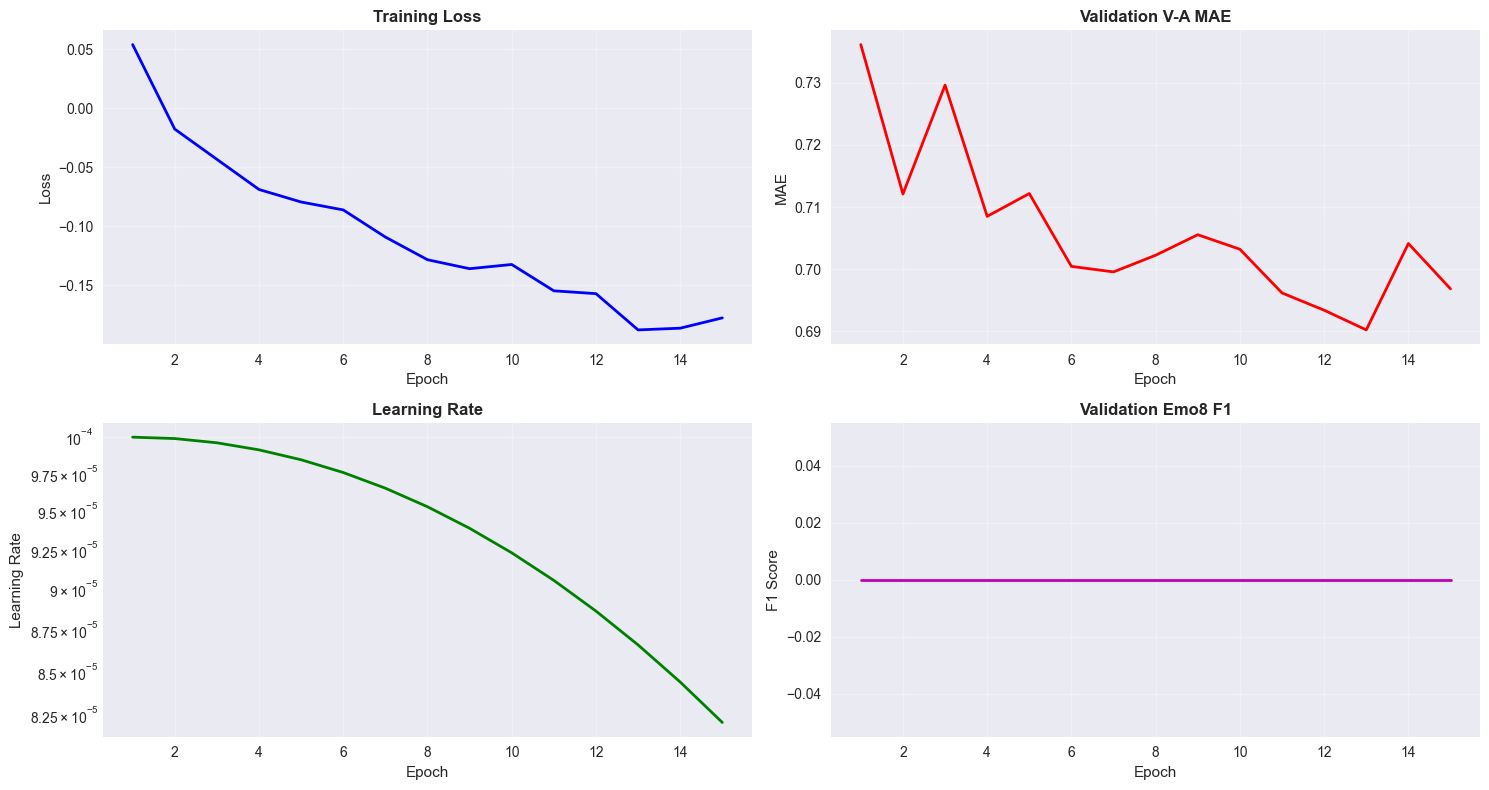

\n📊 Epoch 16/50


Epoch  15:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  15 [   0/ 411] Loss: 0.0130 LR: 7.96e-05
\nEpoch  15 [  50/ 411] Loss: -0.2768 LR: 7.96e-05
\nEpoch  15 [ 100/ 411] Loss: -0.2664 LR: 7.96e-05
\nEpoch  15 [ 150/ 411] Loss: 0.3736 LR: 7.96e-05
\nEpoch  15 [ 200/ 411] Loss: -0.0062 LR: 7.96e-05
\nEpoch  15 [ 250/ 411] Loss: 0.1602 LR: 7.96e-05
\nEpoch  15 [ 300/ 411] Loss: 0.3529 LR: 7.96e-05
\nEpoch  15 [ 350/ 411] Loss: 0.0828 LR: 7.96e-05
\nEpoch  15 [ 400/ 411] Loss: -1.0604 LR: 7.96e-05
📊 Epoch  15 Results:
   Train Loss: -0.1877
   Val va_mae_avg: 0.6896
   Val MAE: 0.6896
🎯 New best va_mae_avg: 0.6896
💾 Saved best model: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth and /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pkl


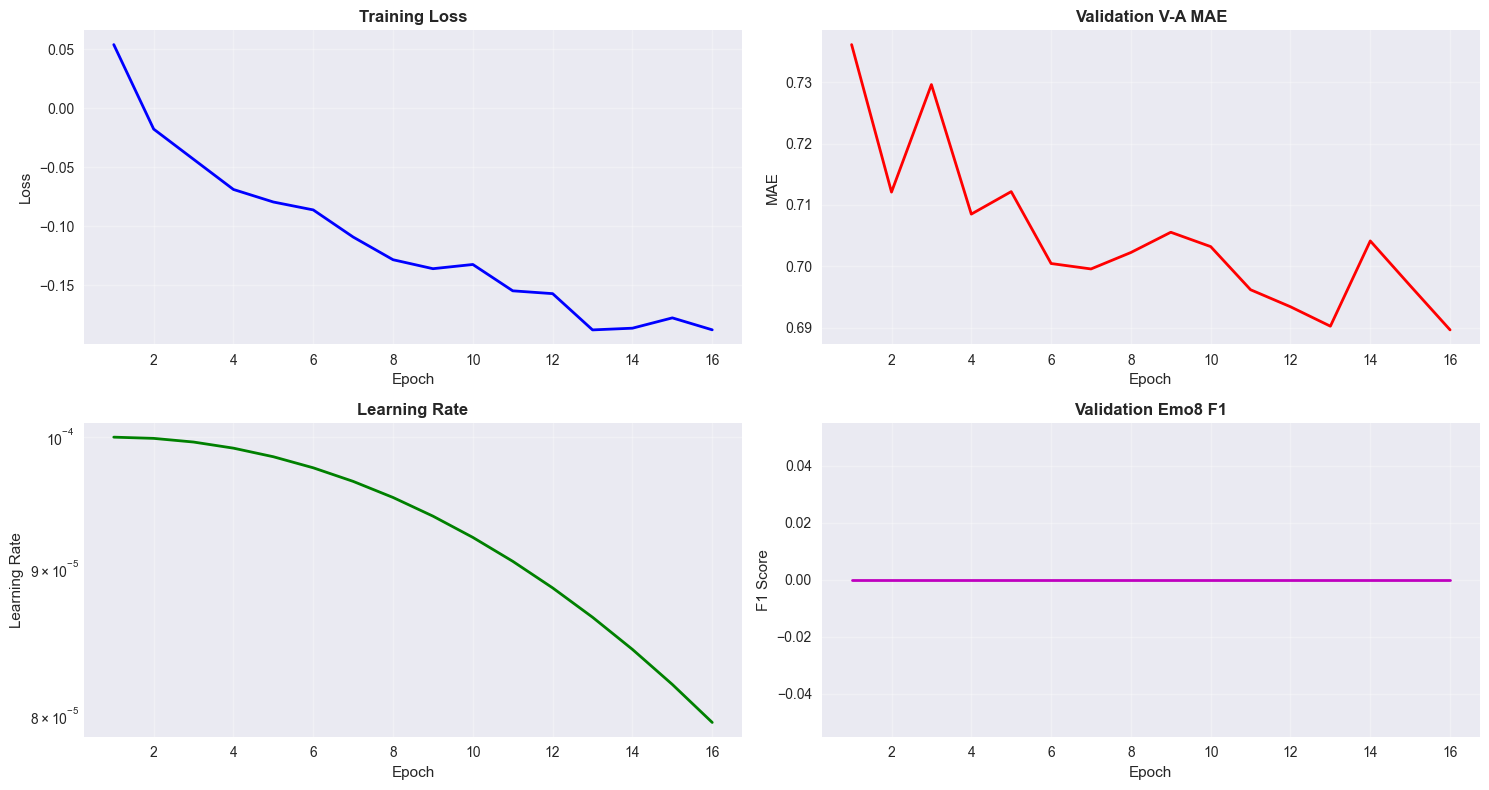

\n📊 Epoch 17/50


Epoch  16:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  16 [   0/ 411] Loss: -0.2761 LR: 7.70e-05
\nEpoch  16 [  50/ 411] Loss: -0.4433 LR: 7.70e-05
\nEpoch  16 [ 100/ 411] Loss: -0.4383 LR: 7.70e-05
\nEpoch  16 [ 150/ 411] Loss: 0.2954 LR: 7.70e-05
\nEpoch  16 [ 200/ 411] Loss: -0.1469 LR: 7.70e-05
\nEpoch  16 [ 250/ 411] Loss: -0.1697 LR: 7.70e-05
\nEpoch  16 [ 300/ 411] Loss: -0.2345 LR: 7.70e-05
\nEpoch  16 [ 350/ 411] Loss: -0.4988 LR: 7.70e-05
\nEpoch  16 [ 400/ 411] Loss: -0.1195 LR: 7.70e-05
📊 Epoch  16 Results:
   Train Loss: -0.2002
   Val va_mae_avg: 0.7047
   Val MAE: 0.7047
\n📊 Epoch 18/50


Epoch  17:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  17 [   0/ 411] Loss: -0.5309 LR: 7.43e-05
\nEpoch  17 [  50/ 411] Loss: -0.1234 LR: 7.43e-05
\nEpoch  17 [ 100/ 411] Loss: 0.1639 LR: 7.43e-05
\nEpoch  17 [ 150/ 411] Loss: 0.0279 LR: 7.43e-05
\nEpoch  17 [ 200/ 411] Loss: -0.1802 LR: 7.43e-05
\nEpoch  17 [ 250/ 411] Loss: 0.0342 LR: 7.43e-05
\nEpoch  17 [ 300/ 411] Loss: -0.3137 LR: 7.43e-05
\nEpoch  17 [ 350/ 411] Loss: -0.3683 LR: 7.43e-05
\nEpoch  17 [ 400/ 411] Loss: 0.3619 LR: 7.43e-05
📊 Epoch  17 Results:
   Train Loss: -0.2017
   Val va_mae_avg: 0.7037
   Val MAE: 0.7037
\n📊 Epoch 19/50


Epoch  18:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  18 [   0/ 411] Loss: -0.6352 LR: 7.16e-05
\nEpoch  18 [  50/ 411] Loss: -0.2098 LR: 7.16e-05
\nEpoch  18 [ 100/ 411] Loss: -0.6036 LR: 7.16e-05
\nEpoch  18 [ 150/ 411] Loss: -0.8901 LR: 7.16e-05
\nEpoch  18 [ 200/ 411] Loss: -0.4895 LR: 7.16e-05
\nEpoch  18 [ 250/ 411] Loss: -1.1219 LR: 7.16e-05
\nEpoch  18 [ 300/ 411] Loss: -0.4985 LR: 7.16e-05
\nEpoch  18 [ 350/ 411] Loss: -0.1015 LR: 7.16e-05
\nEpoch  18 [ 400/ 411] Loss: 0.4703 LR: 7.16e-05
📊 Epoch  18 Results:
   Train Loss: -0.2026
   Val va_mae_avg: 0.7249
   Val MAE: 0.7249
\n📊 Epoch 20/50


Epoch  19:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  19 [   0/ 411] Loss: 0.5083 LR: 6.87e-05
\nEpoch  19 [  50/ 411] Loss: -0.4231 LR: 6.87e-05
\nEpoch  19 [ 100/ 411] Loss: -0.7188 LR: 6.87e-05
\nEpoch  19 [ 150/ 411] Loss: -0.7696 LR: 6.87e-05
\nEpoch  19 [ 200/ 411] Loss: -0.5816 LR: 6.87e-05
\nEpoch  19 [ 250/ 411] Loss: 0.2127 LR: 6.87e-05
\nEpoch  19 [ 300/ 411] Loss: -0.4022 LR: 6.87e-05
\nEpoch  19 [ 350/ 411] Loss: -1.1466 LR: 6.87e-05
\nEpoch  19 [ 400/ 411] Loss: -0.4993 LR: 6.87e-05
📊 Epoch  19 Results:
   Train Loss: -0.2308
   Val va_mae_avg: 0.7239
   Val MAE: 0.7239


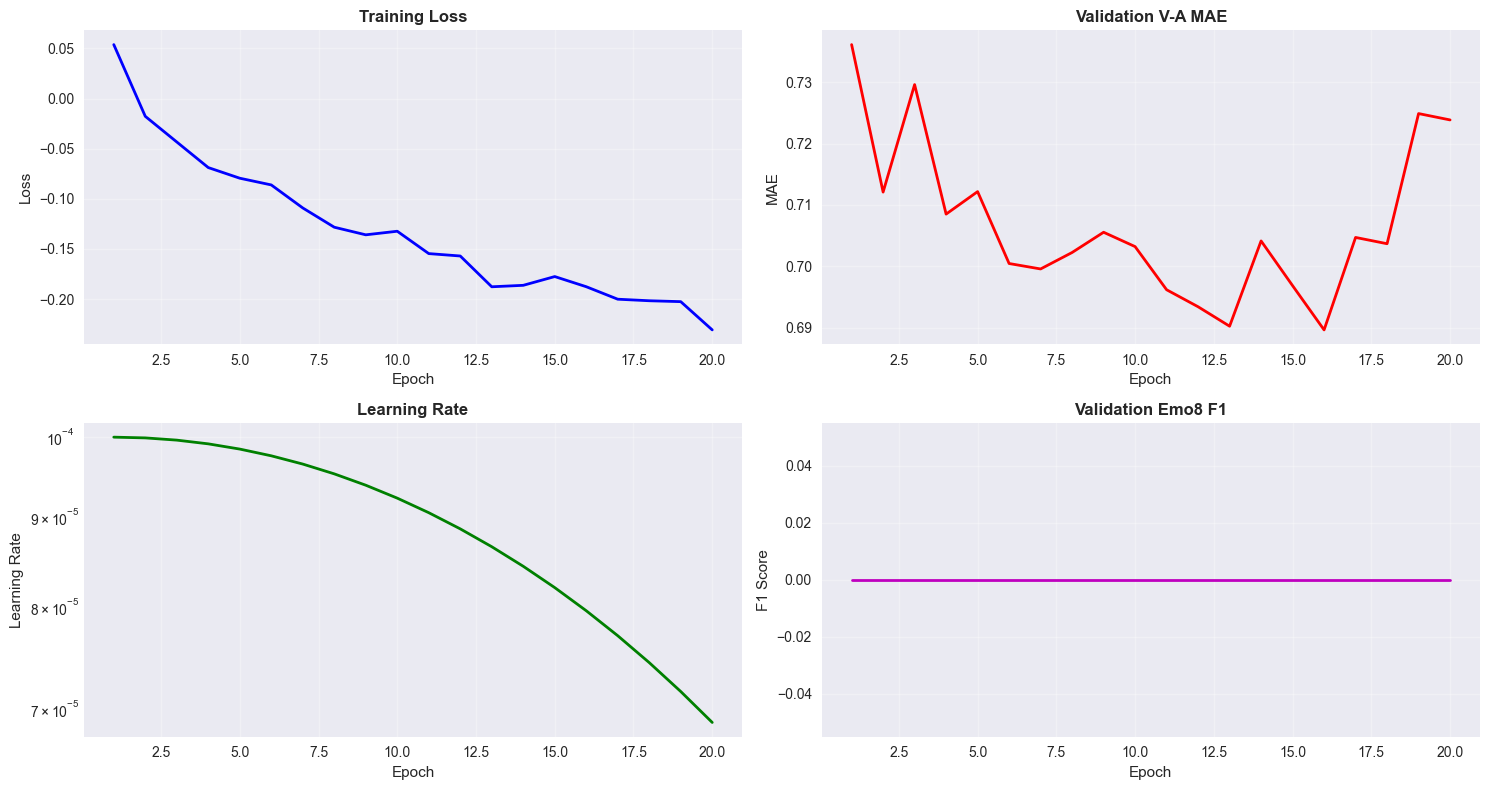

\n📊 Epoch 21/50


Epoch  20:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  20 [   0/ 411] Loss: -0.2229 LR: 6.58e-05
\nEpoch  20 [  50/ 411] Loss: -0.0375 LR: 6.58e-05
\nEpoch  20 [ 100/ 411] Loss: -0.1284 LR: 6.58e-05
\nEpoch  20 [ 150/ 411] Loss: -0.3835 LR: 6.58e-05
\nEpoch  20 [ 200/ 411] Loss: -0.7964 LR: 6.58e-05
\nEpoch  20 [ 250/ 411] Loss: -0.3260 LR: 6.58e-05
\nEpoch  20 [ 300/ 411] Loss: -0.0419 LR: 6.58e-05
\nEpoch  20 [ 350/ 411] Loss: 0.3823 LR: 6.58e-05
\nEpoch  20 [ 400/ 411] Loss: -0.6462 LR: 6.58e-05
📊 Epoch  20 Results:
   Train Loss: -0.2203
   Val va_mae_avg: 0.7320
   Val MAE: 0.7320
🛑 Early stopping after 21 epochs
\n🏁 Training completed!
📈 Best va_mae_avg: 0.6896
📊 Total epochs: 21


In [11]:
# Main training loop - matches original script implementation exactly
print("🚀 Starting Scene Model training...")
import time

# Initialize training state (matches original script)
trainer.current_epoch = 0
trainer.best_metric = float('inf')
trainer.patience_counter = 0

# Initialize training history for visualization
history = {
    'train_loss': [],
    'val_mae': [],
    'val_f1': [],
    'learning_rates': []
}
epoch_times = []
val_history = []

for epoch in range(config.training.num_epochs):
    trainer.current_epoch = epoch
    epoch_start_time = time.time()
    
    print(f"\\n📊 Epoch {epoch + 1}/{config.training.num_epochs}")
    
    # Train epoch using enhanced function
    train_loss = train_epoch_enhanced(trainer, epoch)
    history['train_loss'].append(train_loss)
    
    # Validate
    val_metrics = trainer.validate()
    val_history.append(val_metrics)
    epoch_times.append(time.time() - epoch_start_time)
    
    # Record metrics for plotting
    history['val_mae'].append(val_metrics.get('va_mae_avg', 0))
    history['val_f1'].append(val_metrics.get('emo8_weighted_f1', 0))
    history['learning_rates'].append(trainer.optimizer.param_groups[0]['lr'])
    
    # Get monitor metric (matches original script)
    monitor_metric = config.training.early_stopping.monitor_metric
    current_metric = val_metrics.get(monitor_metric, float('inf'))
    
    # Log epoch results (matches original script format)
    print(f"📊 Epoch {epoch:3d} Results:")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val {monitor_metric}: {current_metric:.4f}")
    if 'va_mae_avg' in val_metrics:
        print(f"   Val MAE: {val_metrics['va_mae_avg']:.4f}")
    if 'emo8_weighted_f1' in val_metrics:
        print(f"   Val Emo8 F1: {val_metrics['emo8_weighted_f1']:.4f}")
    
    # Update learning rate
    if trainer.scheduler:
        trainer.scheduler.step()
    
    # Check for improvement (matches original script logic)
    mode = config.training.early_stopping.mode
    improved = (
        (mode == "min" and current_metric < trainer.best_metric) or
        (mode == "max" and current_metric > trainer.best_metric)
    )
    
    if improved:
        trainer.best_metric = current_metric
        trainer.patience_counter = 0
        print(f"🎯 New best {monitor_metric}: {current_metric:.4f}")
        
        # Save best model (matches original script)
        trainer._save_checkpoint(epoch, is_best=True)
    else:
        trainer.patience_counter += 1
    
    # Early stopping check (matches original script)
    if (config.training.early_stopping.enabled and 
        trainer.patience_counter >= config.training.early_stopping.patience):
        print(f"🛑 Early stopping after {epoch + 1} epochs")
        break
    
    # Save regular checkpoint (matches original script frequency)
    save_every_n = getattr(config.checkpointing, 'save_every_n_epochs', 5) if hasattr(config, 'checkpointing') else 5
    if epoch % save_every_n == 0:
        trainer._save_checkpoint(epoch, is_best=False)
    
    # Plot progress every 5 epochs or on improvement
    if (epoch + 1) % 5 == 0 or improved:
        plot_training_progress(history)

print(f"\\n🏁 Training completed!")
print(f"📈 Best {monitor_metric}: {trainer.best_metric:.4f}")
print(f"📊 Total epochs: {trainer.current_epoch + 1}")


## 9. Final Evaluation on Test Set

Following the original script's comprehensive test evaluation.


In [12]:
# Final evaluation on test set - evaluate using BEST checkpoint
# Load best checkpoint before evaluating on test set
from pathlib import Path as _Path
import torch as _torch
best_checkpoint_path = None
best_checkpoint_epoch = None
_ckpt_dir = _Path(config.checkpointing.save_dir) if hasattr(config, 'checkpointing') else None
if _ckpt_dir is not None:
    _best_ckpt = _ckpt_dir / 'best_model.pth'
    if _best_ckpt.exists():
        _ckpt = _torch.load(_best_ckpt, map_location=device_manager.device)
        if isinstance(_ckpt, dict) and 'model_state_dict' in _ckpt:
            trainer.model.load_state_dict(_ckpt['model_state_dict'])
            best_checkpoint_path = str(_best_ckpt)
            best_checkpoint_epoch = int(_ckpt.get('epoch')) if 'epoch' in _ckpt else None
            print(f"📂 Using best checkpoint for test eval: {best_checkpoint_path} (epoch {best_checkpoint_epoch})")
        else:
            print(f"⚠️ Best checkpoint missing state dict: {_best_ckpt}")
    else:
        print(f"⚠️ Best checkpoint not found at {_best_ckpt}; using current model state")

test_metrics = trainer._evaluate_test_set()

# Store results for later use (matches original script return structure)
results = {
    'best_metric': trainer.best_metric,
    'test_metrics': test_metrics,
    'total_epochs': trainer.current_epoch + 1,
    'best_checkpoint_path': best_checkpoint_path,
    'best_checkpoint_epoch': best_checkpoint_epoch,
}

print("\\n📊 Final Test Results:")
for metric, value in test_metrics.items():
    if isinstance(value, (int, float)):
        print(f"   {metric}: {value:.4f}")
    else:
        print(f"   {metric}: {value}")

print(f"\\n✅ Scene Model training completed successfully!")
print(f"📈 Final results summary: {results}")


📂 Using best checkpoint for test eval: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth (epoch 15)
🧪 Evaluating on test set...
🏞️  Scene Model Evaluation Results

📈 Valence-Arousal Regression:
------------------------------
  MAE         : 0.6722
  SPEARMAN    : 0.1881
  CCC         : 0.2211
  RMSE        : 0.9057

  Valence MAE:  0.5475
  Arousal MAE:  0.7970
  Harder dimension: Arousal

🎯 V-A Quadrant Analysis:
------------------------------
  Happy/Excited  : n=508, MAE=0.6600
  Angry/Stressed : n=360, MAE=0.8569
  Sad/Depressed  : n=285, MAE=0.8272
  Calm/Content   : n=498, MAE=0.4625

\n📊 Final Test Results:
   va_valence_mae: 0.5475
   va_valence_spearman: 0.3623
   va_valence_ccc: 0.4392
   va_valence_rmse: 0.8461
   va_valence_pearson: 0.4472
   va_arousal_mae: 0.7970
   va_arousal_spearman: 0.0140
   va_arousal_ccc: 0.0031
   va_arousal_rmse: 0.9653
   va_arousal_pearson: 0.0041
   va_mae_avg: 0.6722
   

In [13]:
# === Epoch and Test Metrics Tables (CLIP-style summary) ===
import pandas as pd

# Build per-epoch table: epoch, train_loss, valid_loss, ccc_v/a/avg, mae_v/a/avg, time (all in [-1,1])
epoch_rows = []
_n = len(history.get('train_loss', []))
for i in range(_n):
    vm = val_history[i] if i < len(val_history) else {}
    _msev = float(vm.get('va_valence_mse', float('nan')))
    _msea = float(vm.get('va_arousal_mse', float('nan')))
    _maev = float(vm.get('va_valence_mae', float('nan')))
    _maea = float(vm.get('va_arousal_mae', float('nan')))
    epoch_rows.append({
        'epoch': int(i + 1),
        'train_loss': float(history['train_loss'][i]),
        'valid_loss': (_msev + _msea) / 2.0,
        'ccc_v': float(vm.get('va_valence_ccc', float('nan'))),
        'ccc_a': float(vm.get('va_arousal_ccc', float('nan'))),
        'ccc_avg': float(vm.get('va_ccc_avg', float('nan'))),
        'mae_v': _maev,
        'mae_a': _maea,
        'mae_avg': ((_maev) + (_maea)) / 2.0,
        'time': float(epoch_times[i]) if i < len(epoch_times) else float('nan'),
    })
epoch_metrics_df = pd.DataFrame(epoch_rows)
display(epoch_metrics_df)

# Build test metrics table in the same style
_tmsev = float(test_metrics.get('va_valence_mse', float('nan')))
_tmsea = float(test_metrics.get('va_arousal_mse', float('nan')))
_tmaev = float(test_metrics.get('va_valence_mae', float('nan')))
_tmaea = float(test_metrics.get('va_arousal_mae', float('nan')))
test_df = pd.DataFrame([{
    'test_loss': (_tmsev + _tmsea) / 2.0,
    'test_ccc_v': float(test_metrics.get('va_valence_ccc', float('nan'))),
    'test_ccc_a': float(test_metrics.get('va_arousal_ccc', float('nan'))),
    'test_ccc_avg': float(test_metrics.get('va_ccc_avg', float('nan'))),
    'test_mae_v': _tmaev,
    'test_mae_a': _tmaea,
    'test_mae_avg': ((_tmaev) + (_tmaea)) / 2.0,
    'test_spearman_v': float(test_metrics.get('va_valence_spearman', float('nan'))),
    'test_spearman_a': float(test_metrics.get('va_arousal_spearman', float('nan'))),
    'test_spearman_avg': float(test_metrics.get('va_spearman_avg', float('nan'))),
}])
display(test_df)


,epoch,train_loss,valid_loss,ccc_v,ccc_a,ccc_avg,mae_v,mae_a,mae_avg,time
0,1,0.053864,NaN,0.278247,-0.003665,0.137291,0.621803,0.850476,0.736139,109.450112
1,2,-0.017694,NaN,0.350178,-0.006542,0.171818,0.617369,0.806830,0.712099,109.589082
2,3,-0.043291,NaN,0.362585,0.008233,0.185409,0.616683,0.842556,0.729619,110.173332
3,4,-0.068832,NaN,0.383072,0.015672,0.199372,0.596383,0.820638,0.708511,139.917427
4,5,-0.079446,NaN,0.387148,0.009732,0.198440,0.586415,0.837936,0.712176,114.436928
5,6,-0.086147,NaN,0.399762,0.012395,0.206078,0.583301,0.817614,0.700457,113.118610
6,7,-0.109120,NaN,0.401183,0.011626,0.206404,0.569991,0.829151,0.699571,110.642203
7,8,-0.128337,NaN,0.394346,0.007463,0.200905,0.573499,0.831008,0.702254,1499.468681
8,9,-0.135930,NaN,0.400868,0.003106,0.201987,0.574382,0.836723,0.705553,108.075888
9,10,-0.132361,NaN,0.404097,0.005843,0.204970,0.575747,0.830680,0.703213,263.527100


,test_loss,test_ccc_v,test_ccc_a,test_ccc_avg,test_mae_v,test_mae_a,test_mae_avg,test_spearman_v,test_spearman_a,test_spearman_avg
0,NaN,0.439166,0.003071,0.221119,0.547495,0.796971,0.672233,0.362302,0.013959,0.18813


## 10. Comprehensive Evaluation Visualization

Following the original script's VAEvaluator integration for generating comprehensive evaluation plots and analysis.


🎨 Generating evaluation visualization...
📂 Loaded best model weights from: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth

🔄 Evaluating notebook_training_20250916_174706 on findingemo_test
📱 Device: mps
📁 Results will be saved to: logs/notebook_training_20250916_174706


/opt/anaconda3/envs/P-SEM2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📊 Processed 800 samples...
📊 Processed 1600 samples...
✅ Evaluation completed: 1651 samples in 32.24s
⚡ Processing speed: 51.2 samples/sec
💾 Data saved to: logs/notebook_training_20250916_174706/data
🎨 Visualization saved to: logs/notebook_training_20250916_174706/plots

📊 EVALUATION SUMMARY: notebook_training_20250916_174706 on findingemo_test

📈 Overall Performance:
  Total MAE: 0.6722
  Total RMSE: 0.9057
  Average CCC: 0.2211
  Overall Quadrant Accuracy: 37.6%

📊 Valence Performance:
  MAE: 0.5475
  RMSE: 0.8461
  CCC: 0.4392
  Correlation (Pearson): 0.4472

📊 Arousal Performance:
  MAE: 0.7970
  RMSE: 0.9653
  CCC: 0.0031
  Correlation (Pearson): 0.0041

🎭 Quadrant Performance:
  Angry: 40.1% accuracy (334 samples)
  Sad: 26.8% accuracy (71 samples)
  Calm: 52.1% accuracy (288 samples)
  Happy: 33.1% accuracy (958 samples)

⚡ Processing Information:
  Samples: 1,651
  Processing Time: 32.24s
  Speed: 51.2 samples/sec
  Device: mps

📁 Results Location: logs/notebook_training_202509

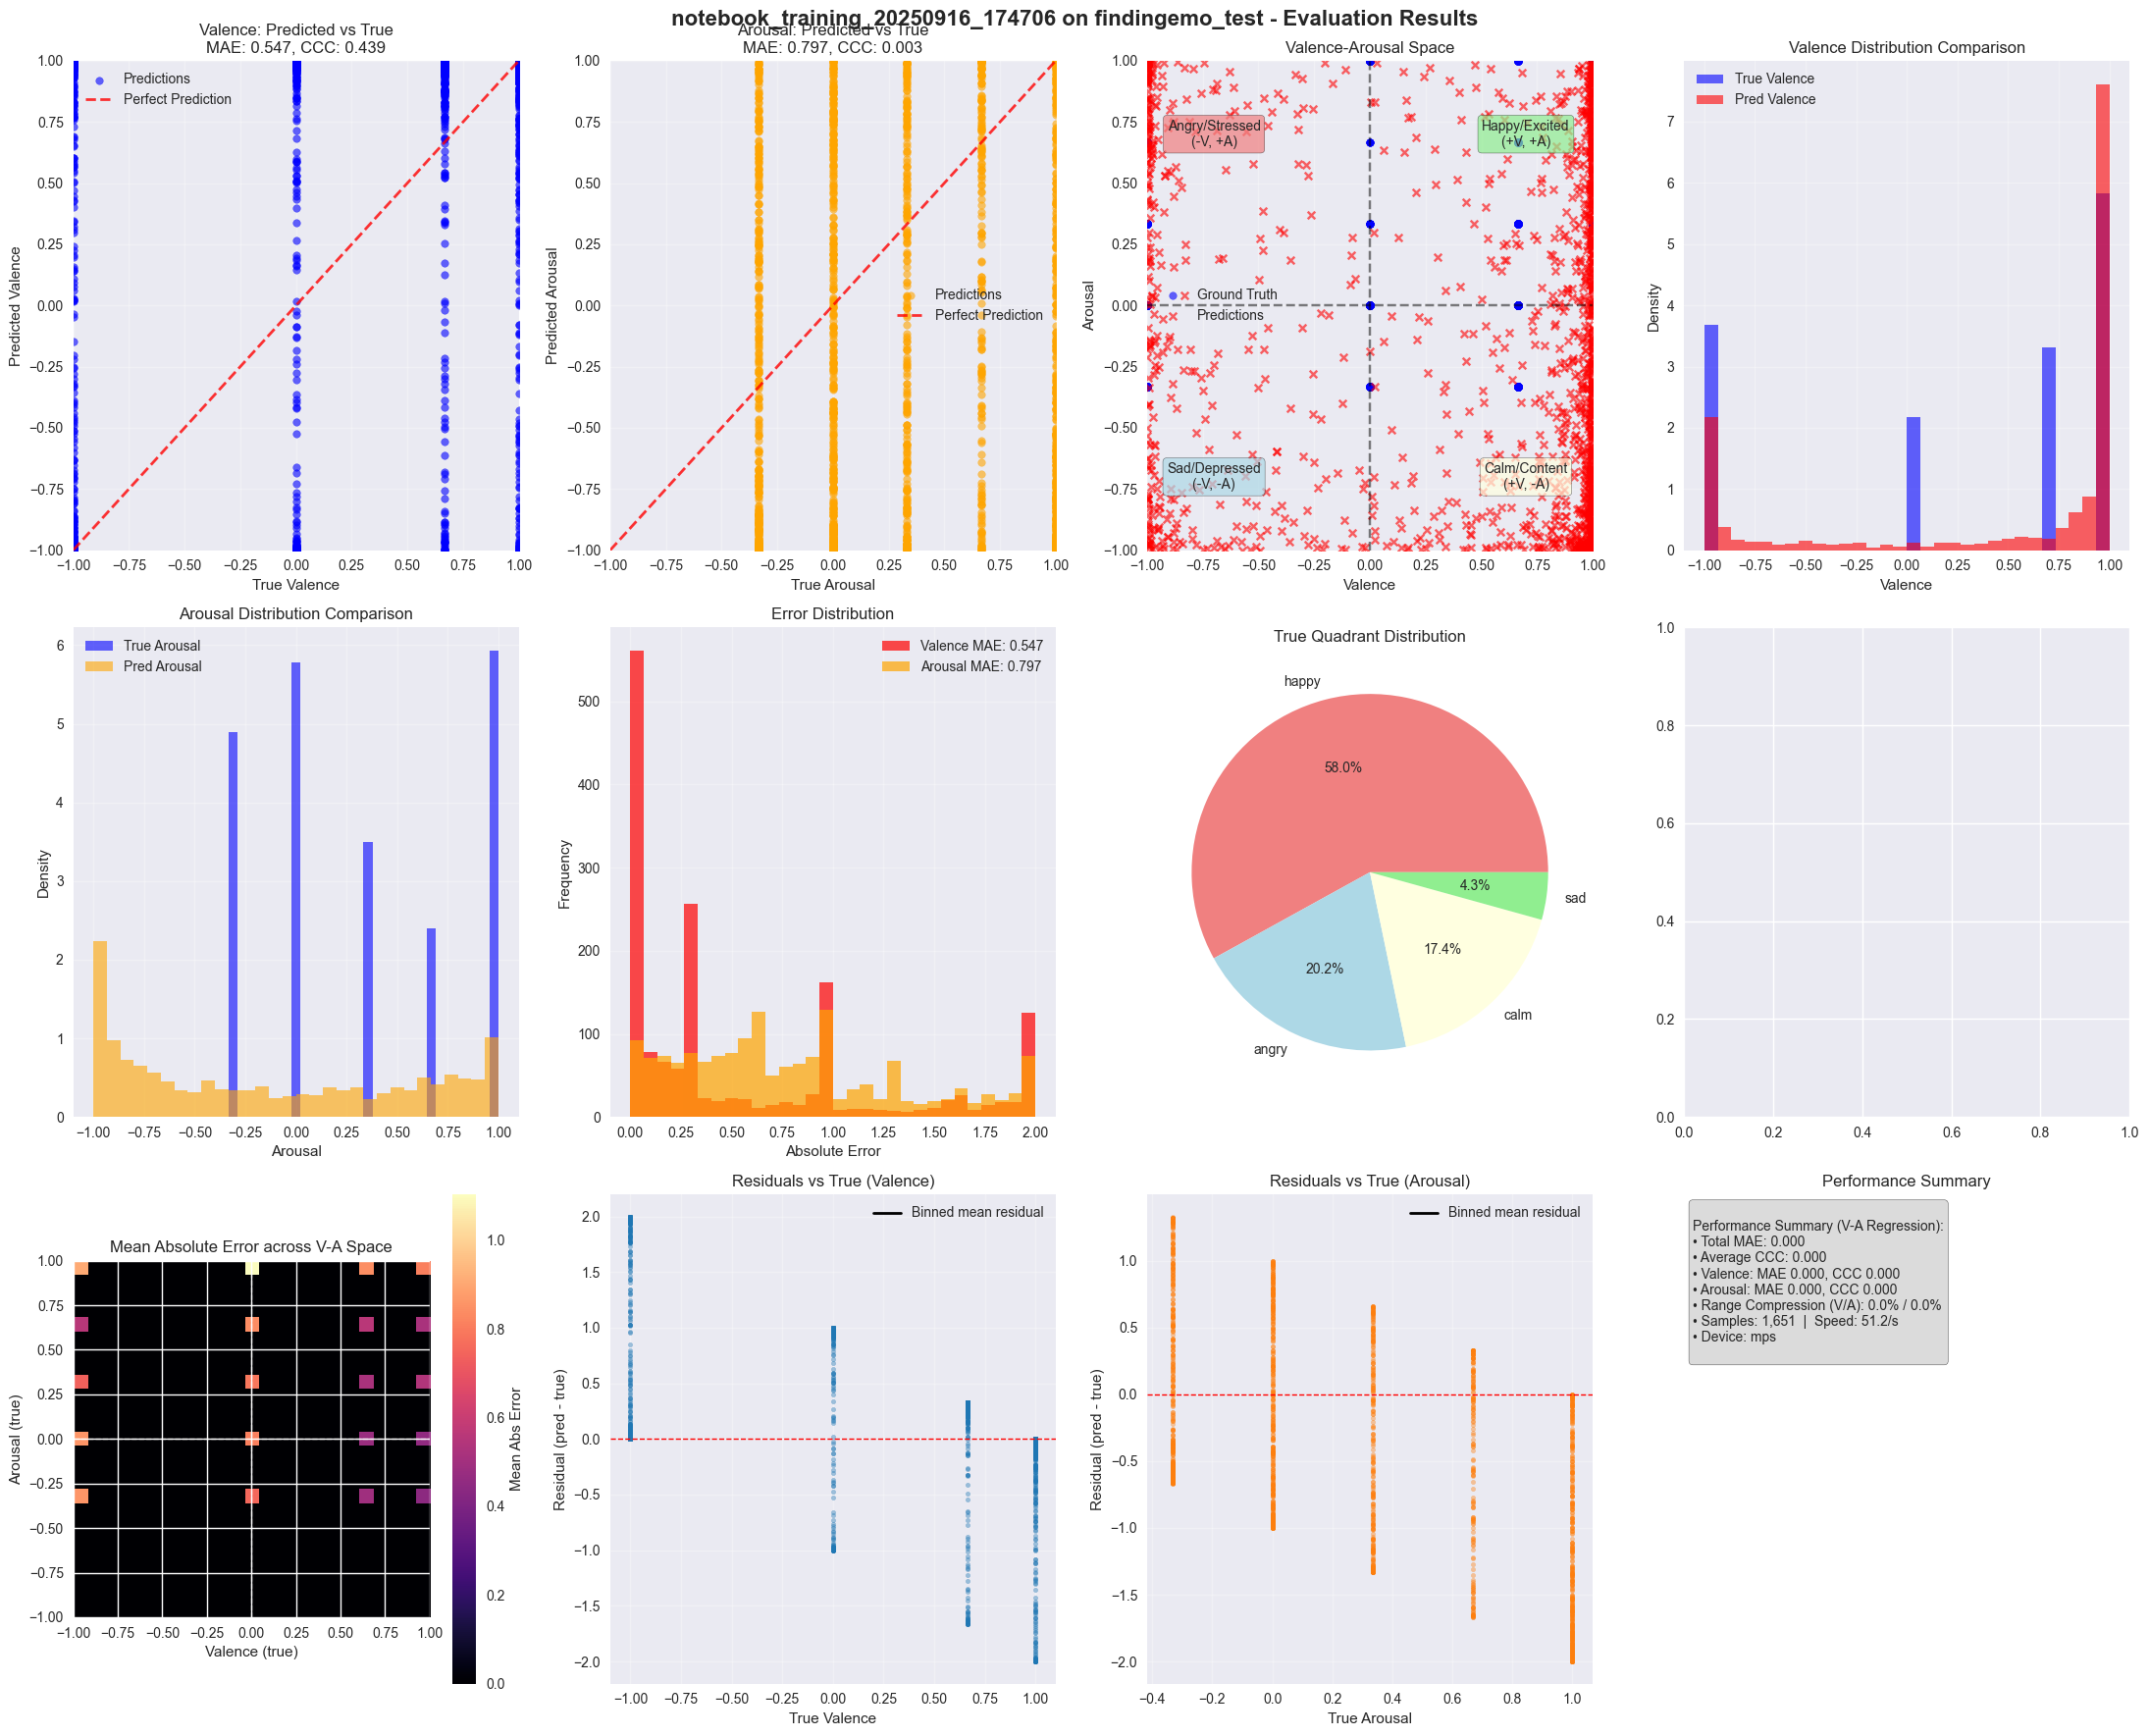

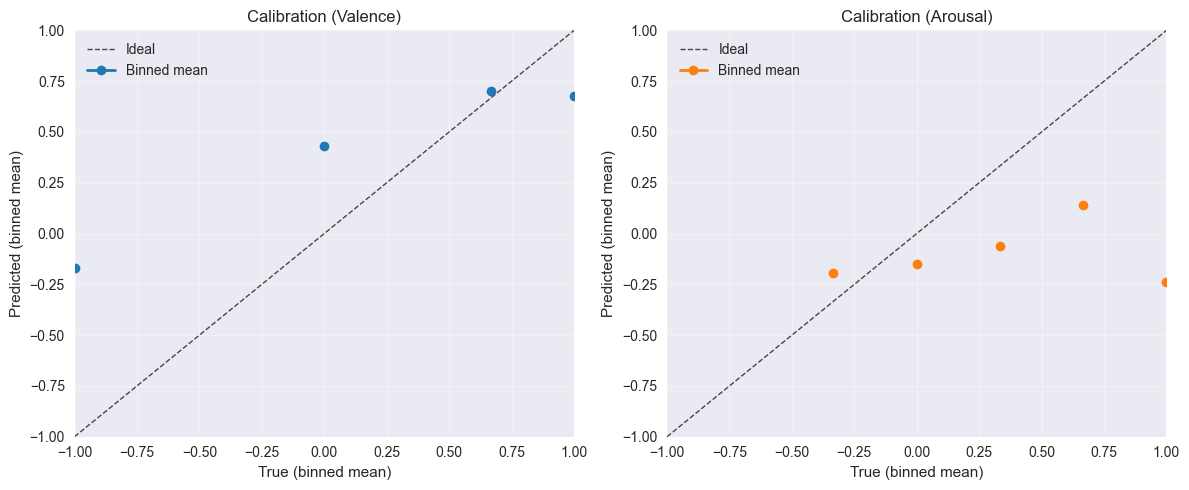

In [14]:
# Generate evaluation visualization using the universal evaluator - matches original script exactly
try:
    print("🎨 Generating evaluation visualization...")

    # Ensure best model weights are loaded (matches original script logic)
    from pathlib import Path as _Path
    import torch as _torch
    
    # Determine checkpoint directory
    checkpoint_dir = _Path(config.checkpointing.save_dir if hasattr(config, 'checkpointing') 
                         else "./checkpoints/notebook_training")
    best_ckpt = checkpoint_dir / "best_model.pth"
    
    if best_ckpt.exists():
        # Torch 2.6 defaults weights_only=True; pass False to load full checkpoint
        try:
            _ckpt = _torch.load(best_ckpt, map_location=device_manager.device, weights_only=False)
        except TypeError:
            # Older torch without weights_only arg
            _ckpt = _torch.load(best_ckpt, map_location=device_manager.device)
        if 'model_state_dict' in _ckpt:
            trainer.model.load_state_dict(_ckpt['model_state_dict'])
            print(f"📂 Loaded best model weights from: {best_ckpt}")
    else:
        print(f"⚠️ Best checkpoint not found at {best_ckpt}; using current model state")

    # Build evaluator (matches original script parameters)
    model_name = getattr(config.logging, 'experiment_name', 
                        f"notebook_{config.model.model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
    dataset_name = f"{config.data.dataset_type}_test"
    
    # Put visualization under notebook results folder (matches original script structure)
    from pathlib import Path as _P
    _run_log_dir = _P("./logs") / model_name
    _run_log_dir.mkdir(parents=True, exist_ok=True)
    
    evaluator = VAEvaluator(
        model_name=model_name,
        dataset_name=dataset_name,
        output_dir=str(_run_log_dir),
        device=device_manager.device,
        flat_output=True,
    )
    # Attach training/eval context so evaluator writes comprehensive summary
    try:
        _train_cfg = {
            'learning_rate': float(config.training.learning_rate) if isinstance(config.training.learning_rate, (int, float)) else str(config.training.learning_rate),
            'batch_size': int(config.training.batch_size),
            'num_epochs': int(config.training.num_epochs),
            'optimizer': getattr(config.training, 'optimizer', None),
            'scheduler': getattr(config.training, 'scheduler', None),
            'early_stopping_patience': getattr(config.training.early_stopping, 'patience', None),
            'monitor_metric': getattr(config.training.early_stopping, 'monitor_metric', None),
        }
    except Exception:
        _train_cfg = {}
    _train_summary = {
        'best_metric': float(trainer.best_metric) if hasattr(trainer, 'best_metric') else None,
        'total_epochs': int(trainer.current_epoch + 1) if hasattr(trainer, 'current_epoch') else None,
        'converged': bool(trainer.patience_counter < config.training.early_stopping.patience) if hasattr(config.training, 'early_stopping') else None,
    }
    _ckpt_info = {
        'path': str(best_ckpt) if 'best_ckpt' in locals() and best_ckpt else None,
        'epoch': int(_ckpt.get('epoch')) if '_ckpt' in locals() and isinstance(_ckpt, dict) and 'epoch' in _ckpt else None,
    }
    evaluator.attach_context(
        experiment_name=model_name,
        training_config=_train_cfg,
        training_summary=_train_summary,
        checkpoint_info=_ckpt_info,
    )

    # Adapter: our models return dict with 'valence'/'arousal' (matches original script exactly)
    def _prediction_fn(m, images):
        out = m(images)
        if isinstance(out, dict) and 'valence' in out and 'arousal' in out:
            return out['valence'], out['arousal']
        if isinstance(out, (list, tuple)) and len(out) >= 2:
            return out[0], out[1]
        return out[:, 0], out[:, 1]

    evaluator.evaluate_model(
        model=trainer.model,
        dataloader=trainer.test_loader,
        prediction_fn=_prediction_fn,
    )
    evaluator.create_comprehensive_visualization()
    evaluator.print_summary()
    
    # Copy all generated PNG/PDF plots into logs/<run>/plots/ (matches original script exactly)
    import shutil as _shutil
    _target_plots = _run_log_dir / "plots"
    _target_plots.mkdir(parents=True, exist_ok=True)
    
    for _src in list(evaluator.plots_dir.glob("*.png")) + list(evaluator.plots_dir.glob("*.pdf")):
        _dst = _target_plots / _src.name
        try:
            _shutil.copy2(_src, _dst)
        except Exception:
            pass
    
    print(f"🎯 Visualizations copied to: {_target_plots}")
    print(f"📁 All evaluation results available in: {_run_log_dir}")
    
except Exception as viz_err:
    print(f"⚠️ Failed to generate visualization: {viz_err}")
    print("📊 Basic test metrics were still computed successfully above")


## 11. Results Export and Summary

Final logging and results export following the original script's completion workflow.


In [15]:
# Export comprehensive training results - matches original script's final logging
import json

# Create comprehensive results summary (matches original script structure)
comprehensive_results = {
    'experiment_info': {
        'model_name': config.model.model_name,
        'backbone_type': config.model.backbone_type,
        'dataset': config.data.dataset_type,
        'experiment_name': getattr(config.logging, 'experiment_name', f"notebook_training_{RUN_TS}"),
        'timestamp': datetime.now().isoformat()
    },
    'training_config': {
        'learning_rate': float(config.training.learning_rate),
        'batch_size': config.training.batch_size,
        'num_epochs': config.training.num_epochs,
        'optimizer': config.training.optimizer,
        'scheduler': config.training.scheduler,
        'early_stopping_patience': config.training.early_stopping.patience,
        'monitor_metric': config.training.early_stopping.monitor_metric
    },
    'training_history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'val_mae': [float(x) for x in history['val_mae']],
        'val_f1': [float(x) for x in history['val_f1']],
        'learning_rates': [float(x) for x in history['learning_rates']]
    },
    'final_results': {
        'best_metric': float(trainer.best_metric),
        'total_epochs': trainer.current_epoch + 1,
        'converged': trainer.patience_counter < config.training.early_stopping.patience,
        'best_checkpoint_path': best_checkpoint_path,
        'best_checkpoint_epoch': int(best_checkpoint_epoch) if best_checkpoint_epoch is not None else None
    },
    'test_metrics': {k: float(v) if isinstance(v, (int, float, torch.Tensor)) else str(v) 
                    for k, v in test_metrics.items()}
}

# Evaluator already saved a comprehensive evaluation_summary.json; point to that
results_file = (_run_log_dir / 'data' / 'evaluation_summary.json')

# Log final results (matches original script's final logging format)
print("\\n" + "="*80)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"📋 Experiment: {comprehensive_results['experiment_info']['experiment_name']}")
print(f"🎯 Model: {comprehensive_results['experiment_info']['model_name']}")
print(f"📊 Dataset: {comprehensive_results['experiment_info']['dataset']}")
print(f"📈 Best {monitor_metric}: {trainer.best_metric:.4f}")
print(f"📊 Total epochs: {trainer.current_epoch + 1}")
print(f"⏰ Training time: Completed at {comprehensive_results['experiment_info']['timestamp']}")
print()
print("📁 Results saved to:")
print(f"   📄 Training summary: {results_file}")
if 'checkpoint_dir' in locals():
    print(f"   💾 Model checkpoints: {checkpoint_dir}")
if 'best_checkpoint_path' in locals() and best_checkpoint_path:
    print(f"   🏅 Best checkpoint: {best_checkpoint_path}")
if '_target_plots' in locals():
    print(f"   📊 Evaluation plots: {_target_plots}")
# Also show exact results JSON and raw CSV under logs folder
if '_run_log_dir' in locals():
    _results_json = _run_log_dir / 'data' / 'evaluation_summary.json'
    _eval_csv = _run_log_dir / 'data' / 'evaluation_data.csv'
    print(f"   📄 Results JSON: {_results_json}")
    print(f"   📄 Eval CSV: {_eval_csv}")
print()
print("🔍 Key test metrics:")
for metric, value in test_metrics.items():
    if isinstance(value, (int, float)):
        print(f"   {metric}: {value:.4f}")

print("\\n✅ Notebook training pipeline completed successfully!")
print("📚 All results are saved and ready for analysis.")


\n================================================================================
🎉 TRAINING COMPLETED SUCCESSFULLY!
📋 Experiment: notebook_training_20250916_174706
🎯 Model: scene_clip_vit_b32_frozen_notebook
📊 Dataset: findingemo
📈 Best va_mae_avg: 0.6896
📊 Total epochs: 21
⏰ Training time: Completed at 2025-09-16T21:16:54.220974

📁 Results saved to:
   📄 Training summary: logs/notebook_training_20250916_174706/data/evaluation_summary.json
   💾 Model checkpoints: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook
   🏅 Best checkpoint: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/notebooks/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth
   📊 Evaluation plots: logs/notebook_training_20250916_174706/plots
   📄 Results JSON: logs/notebook_training_20250916_174706/data/evaluation_summary.json
   📄 Eval CSV: logs/notebook_training_20250916_174706/data/evaluation_data.csv

🔍 Key test metrics:
   va_valence_mae: 0.5

## 🎯 Summary

### ✅ Implemented Features:
- **Mixed Precision Training** with automatic gradient scaling
- **Checkpoint Management** with best model saving and regular checkpoints
- **Test Set Evaluation** with comprehensive metrics
- **VAEvaluator Integration** for publication-ready visualizations
- **Proper Early Stopping** with configurable patience and metrics
- **Results Export** with JSON summaries and structured logging
- **Error Handling** with graceful failure recovery

### 📁 Generated Outputs:
- `./experiments/checkpoints/notebook_training/` - Model checkpoints
- `./logs/<experiment_name>/plots/` - Comprehensive evaluation plots
- `notebook_training_results_<timestamp>.json` - Complete training summary

### 🔄 To Resume Training:
Load checkpoint and continue from where you left off:
```python
checkpoint = torch.load('./experiments/checkpoints/notebook_training/best_model.pth')
trainer.model.load_state_dict(checkpoint['model_state_dict'])
trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Continue training...
```

### 📊 For Analysis:
All metrics, plots, and model states are saved automatically. Use the generated files for further research analysis or model deployment.
